# 1 - Imports

In [137]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import joblib
import random
from IPython.display import Image
from tabulate import tabulate
from pycorrcat.pycorrcat import corr_matrix
from boruta import BorutaPy
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import ExtraTreesClassifier, RandomForestClassifier
import scikitplot as skplt
from warnings import filterwarnings

In [3]:
filterwarnings('ignore')

pd.set_option('display.max_columns', None)
pd.set_option( 'display.expand_frame_repr', False )

%matplotlib inline
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = [18, 8]

sns.set;

## 1.1 - Funções

In [4]:
def precision(data, pred, percent):
    '''Contar quantas predições foram corretas até k e dividir por todas as predições realizadas pelo modelo até k.
    data: dataset
    pred: probabilidade medida pelo modelo (predict_proba)
    k: porcentagem do dataset'''
    # Porcentagem
    k=int(len(data)*percent)
    
    # Score
    data['score'] = pred[:, 1].tolist()

    # Ordenando o cliente pelo score
    data = data.sort_values('score', ascending=False)

    # Resetando o index
    data = data.reset_index(drop=True)

    # Criando a ordem do ranking
    data['ranking'] = data.index + 1 
    
    # Calculando a precisão
    data['precision_at_k'] = data['response'].cumsum() / data['ranking']

    return data.loc[k, 'precision_at_k']

def recall(data, pred, percent):
    '''Contar quantos predições foram corretas até k e dividir por todos os exemplos verdadeiros
    data: dataset
    pred: probabilidade medida pelo modelo (predict_proba)
    k: porcentagem do dataset'''
    # Porcentagem
    k=int(len(data)*percent)
    
    # Score
    data['score'] = pred[:, 1].tolist()

    # Ordenando o cliente pelo score
    data = data.sort_values('score', ascending=False)
    
    # Resetando o index
    data = data.reset_index(drop=True)

    # Criando a ordem do ranking
    data['ranking'] = data.index + 1 
    
    # Calculando o Recall
    data['recall_at_k'] = data['response'].cumsum() / data['response'].sum()

    return data.loc[k, 'recall_at_k']

def cross_validation(model_name, model, splits, X_train, y_train, percent):
    lista_precision = []
    lista_recall = []
    
    fold = StratifiedKFold(n_splits=splits, shuffle=True, random_state=42)
    
    for train, test in fold.split(X_train, y_train):
        # Treino
        X_train_fold = X_train.iloc[train]
        y_train_fold = y_train.iloc[train]
        
        # Teste
        X_test_fold = X_train.iloc[test]
        y_test_fold = y_train.iloc[test]
        
        # Treinando o modelo
        model_fit = model.fit(X_train_fold, y_train_fold)
        
        # Predict Score
        y_pred = model_fit.predict_proba(X_test_fold)
        
        X_test_fold['response'] = y_test_fold
        
        # Precisão top K
        lista_precision.append(precision(X_test_fold, y_pred, percent))
        lista_recall.append(recall(X_test_fold, y_pred, percent))
        
    # Média das métricas
    mean_precision = np.round(np.mean(lista_precision),2)
    mean_recall = np.round(np.mean(lista_recall),2)
    
    # Desvio padrão das métricas
    std_precision = np.round(np.std(lista_precision),2)
    std_recall = np.round(np.std(lista_recall),2)
    
    precision_top_k = 'mean: ' + mean_precision.astype(str) + ' | ' + 'std: ' + ' +/- ' + std_precision.astype(str)
    recall_top_k = 'mean: ' + mean_recall.astype(str) + ' | ' + 'std: ' + ' +/- ' + std_recall.astype(str)
    
    data = {'model_name': model_name, 'Precision':precision_top_k, 'Recall':recall_top_k}
    df = pd.DataFrame(data, index=[0])
        
    return df

## 1.2 - Cargando os dados

In [5]:
df = pd.read_csv('../data/train.csv')

In [6]:
df.head()

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
0,1,Male,44,1,28.0,0,> 2 Years,Yes,40454.0,26.0,217,1
1,2,Male,76,1,3.0,0,1-2 Year,No,33536.0,26.0,183,0
2,3,Male,47,1,28.0,0,> 2 Years,Yes,38294.0,26.0,27,1
3,4,Male,21,1,11.0,1,< 1 Year,No,28619.0,152.0,203,0
4,5,Female,29,1,41.0,1,< 1 Year,No,27496.0,152.0,39,0


# 2 - Descrição dos dados

In [7]:
df2 = df.copy()

## 2.1 - Dimensão do dataset

In [8]:
print(f'Quantidade de linhas: {df2.shape[0]}')
print(f'Quantidade de colunas: {df2.shape[1]}')

Quantidade de linhas: 381109
Quantidade de colunas: 12


## 2.2 - Renomear as colunas

In [9]:
new_columns = []
for e in df2.columns:
    new_columns.append(e.lower())

df2.columns = new_columns

## 2.3 - Tipos dos dados

In [10]:
df2.dtypes

id                        int64
gender                   object
age                       int64
driving_license           int64
region_code             float64
previously_insured        int64
vehicle_age              object
vehicle_damage           object
annual_premium          float64
policy_sales_channel    float64
vintage                   int64
response                  int64
dtype: object

## 2.4 - Dados nulos

In [11]:
df2.isnull().sum()

id                      0
gender                  0
age                     0
driving_license         0
region_code             0
previously_insured      0
vehicle_age             0
vehicle_damage          0
annual_premium          0
policy_sales_channel    0
vintage                 0
response                0
dtype: int64

## <font color=red> 2.5 - Correção dados nulos (não necessário) </font>

## <font color=red>2.6 - Alteração dos tipos dos dados (não necessário)</font>

## 2.7 - Análise descritiva

In [12]:
num = df2.select_dtypes(include=['int64', 'float64'])
cat = df2.select_dtypes(exclude=['int64', 'float64'])

### 2.7.1 - Análise numérica

In [13]:
# média, desvio padrão, mínimo, quartis, máximo
desc = num.describe().T
desc.drop('count', axis=1, inplace=True)

# mediana
median = pd.DataFrame(num.apply(np.median))
desc.insert(2,'median', median[0].values)

# range
range_ = pd.DataFrame( num.apply( lambda x: x.max() - x.min() ) )
desc.insert(len(desc.columns),'range', range_[0].values)

# trocando o desvio padrão de posição
std = desc.pop('std')
desc.insert(len(desc.columns),'std', std)

# skewness
skew = pd.DataFrame(num.apply(lambda x: x.skew()))
desc.insert(len(desc.columns),'skew', skew[0].values)

# kurtosis
kurtosis = pd.DataFrame(num.apply(lambda x: x.kurtosis()))
desc.insert(len(desc.columns),'kurtosis', kurtosis[0].values)

# Remover 25%, 50% e 75%
desc.drop(['25%', '50%', '75%'], axis=1, inplace=True)

desc

,mean,median,min,max,range,std,skew,kurtosis
id,190555.000000,190555.0,1.0,381109.0,381108.0,110016.836208,9.443274e-16,-1.200000
age,38.822584,36.0,20.0,85.0,65.0,15.511611,6.725390e-01,-0.565655
driving_license,0.997869,1.0,0.0,1.0,1.0,0.046110,-2.159518e+01,464.354302
region_code,26.388807,28.0,0.0,52.0,52.0,13.229888,-1.152664e-01,-0.867857
previously_insured,0.458210,0.0,0.0,1.0,1.0,0.498251,1.677471e-01,-1.971871
annual_premium,30564.389581,31669.0,2630.0,540165.0,537535.0,17213.155057,1.766087e+00,34.004569
policy_sales_channel,112.034295,133.0,1.0,163.0,162.0,54.203995,-9.000081e-01,-0.970810
vintage,154.347397,154.0,10.0,299.0,289.0,83.671304,3.029517e-03,-1.200688
response,0.122563,0.0,0.0,1.0,1.0,0.327936,2.301906e+00,3.298788


### 2.7.2 - Análise categórica

In [14]:
for x in cat.columns:
    print(f'- A coluna {x} tem {cat[x].unique().shape[0]} valores únicos: {cat[x].unique()}')

- A coluna gender tem 2 valores únicos: ['Male' 'Female']
- A coluna vehicle_age tem 3 valores únicos: ['> 2 Years' '1-2 Year' '< 1 Year']
- A coluna vehicle_damage tem 2 valores únicos: ['Yes' 'No']


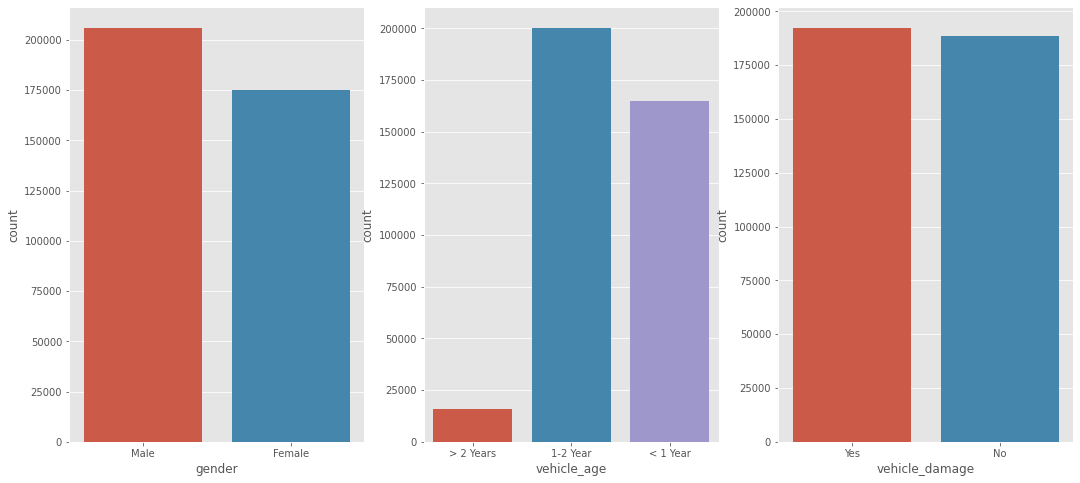

In [15]:
plt.subplot(1, 3, 1)
sns.countplot(x='gender', data=df2)
plt.subplot(1, 3, 2)
sns.countplot(x='vehicle_age', data=df2)
plt.subplot(1, 3, 3)
sns.countplot(x='vehicle_damage',data=df2);

# 3 - Feature engineering

In [16]:
df3 = df2.copy()

## 3.1 - Mapa mental das hipóteses

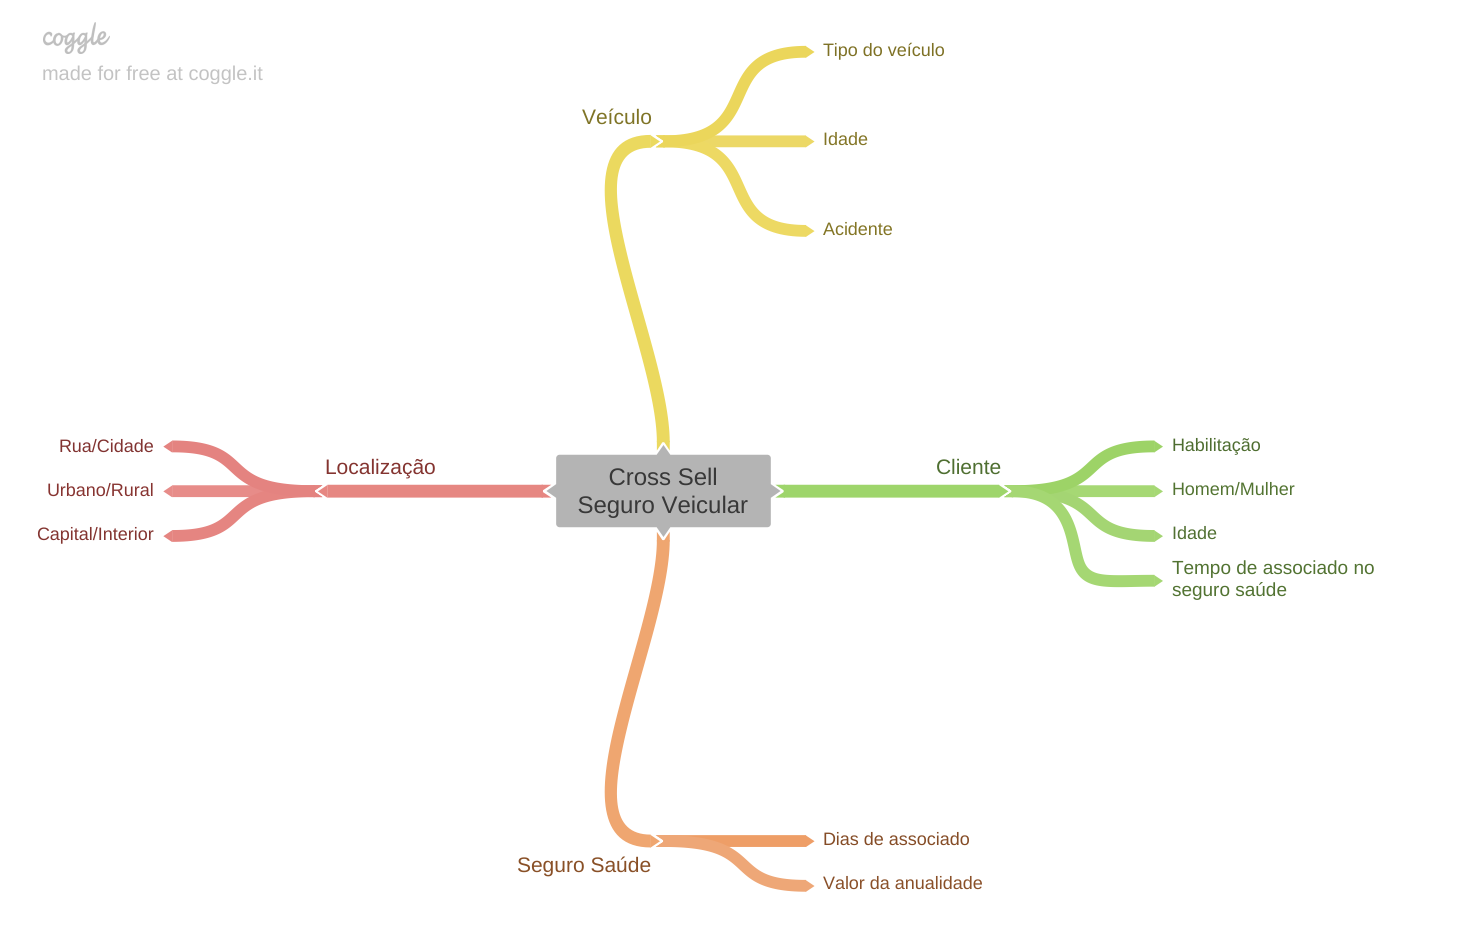

In [18]:
Image('../img/mapa_mental_cross_sell.png')

## 3.2 - Lista das hipóteses

**Gênero/Acidente**  
Hipótese 1 - Homens se acidentam 30% mais que as mulheres.  

**Gênero/Habilitação**  
Hipótese 2 - Há 30% mais homens habilitados do que as mulheres.  

**Gênero/Idade do veículo**  
Hipótese 3 - Mais de 50% das mulheres dirigem carros com menos de 1 ano enquanto mais de 50% dos homens dirigem carros com mais de 2 anos.  

**Gênero/Seguro veicular**    
Hipótese 4 - Mais de 40% de homens e mulheres possuem seguro veicular.  

**Idade/Acidente**  
Hipótese 5 - Pessoas com menos de 40 anos se acidentam 20% mais.  

**Idade/Idade do veículo**  
Hipótese 6 - Mais de 50% pessoas com menos de 40 anos dirigem carros mais novos (com menos de 1 ano), enquanto mais de 40% da pessoas com mais de 40 dirigem carros mais antigos.  
  
**Idade/Seguro veicular**  
Hipótese 7 - Menos de 40% das pessoas com menos de 40 anos dirigem sem seguro no veículo, enquanto mais de 70% das pessoas com mais de 40 anos possuem seguro.  

## 3.4 - Feature engineering

# 4 - Filtragem das variáveis

In [19]:
df4 = df3.copy()

## 4.1 - Seleção das linhas

## 4.2 - Seleção das colunas

# 5 - Análise exploratória dos dados

In [20]:
df5 = df4.copy()

## 5.1 - Análise univariada

### 5.1.1 - Variável resposta

In [21]:
df5['response'].value_counts().reset_index().rename(columns={0:'count'})

,index,response
0,0,334399
1,1,46710


In [22]:
df5['response'].value_counts(normalize=True).reset_index().rename(columns={0:'percent'})

,index,response
0,0,0.877437
1,1,0.122563


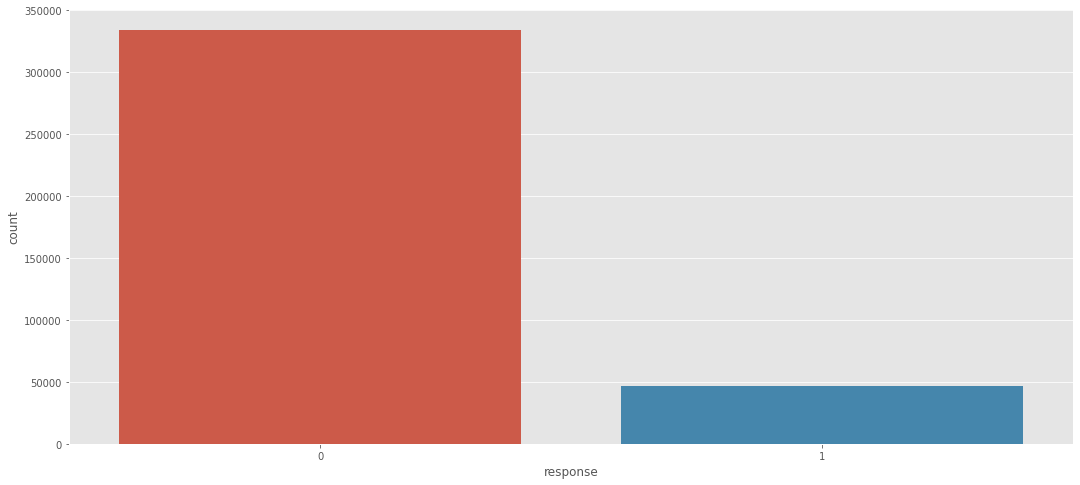

In [23]:
sns.countplot(df5['response']);

### 5.2.1 - Variáveis numéricas

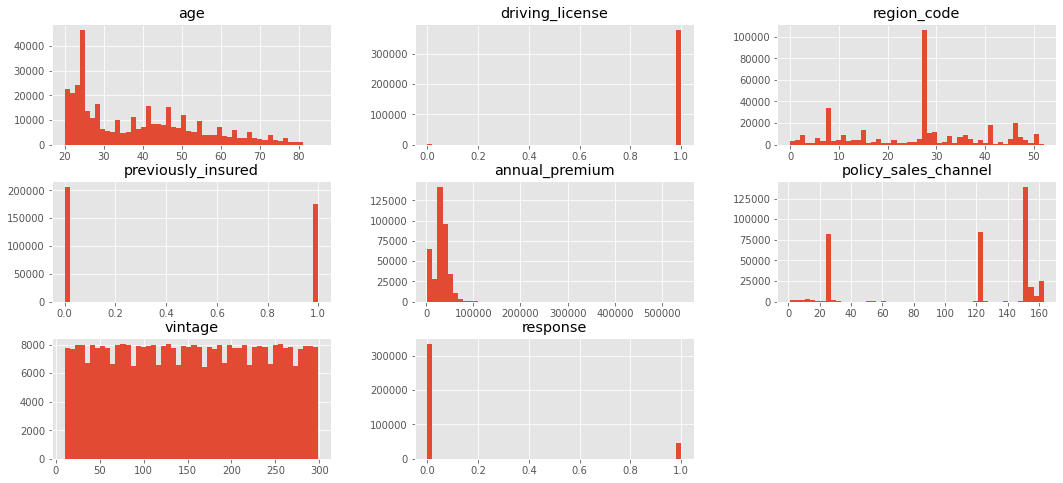

In [24]:
num.drop('id', axis=1).hist(label=num['response'], bins=50);

### 5.1.3 - Variáveis categóricas

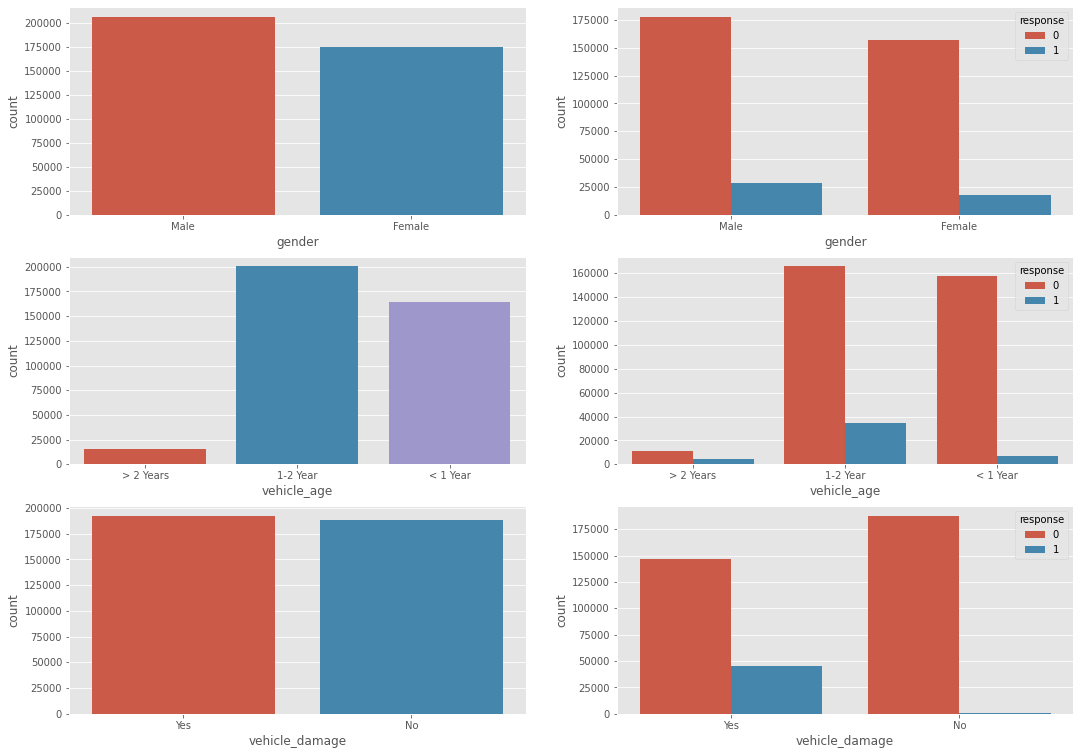

In [25]:
plt.figure(figsize=(18, 13))
plt.subplot(3, 2, 1)
sns.countplot(x='gender', data=df5)

plt.subplot(3, 2, 2)
sns.countplot(x='gender', hue='response', data=df5)

plt.subplot(3, 2, 3)
sns.countplot(x='vehicle_age', data=df5)

plt.subplot(3, 2, 4)
sns.countplot(x='vehicle_age', hue='response', data=df5)

plt.subplot(3, 2, 5)
sns.countplot(x='vehicle_damage', data=df5)

plt.subplot(3, 2, 6)
sns.countplot(x='vehicle_damage', hue='response', data=df5);

### Gender

In [26]:
df5[['gender', 'response']].value_counts().reset_index().rename(columns={0:'count'})

,gender,response,count
0,Male,0,177564
1,Female,0,156835
2,Male,1,28525
3,Female,1,18185


In [27]:
df5[['gender', 'response']].value_counts(normalize=True).reset_index().rename(columns={0:'percent'})

,gender,response,percent
0,Male,0,0.465914
1,Female,0,0.411523
2,Male,1,0.074847
3,Female,1,0.047716


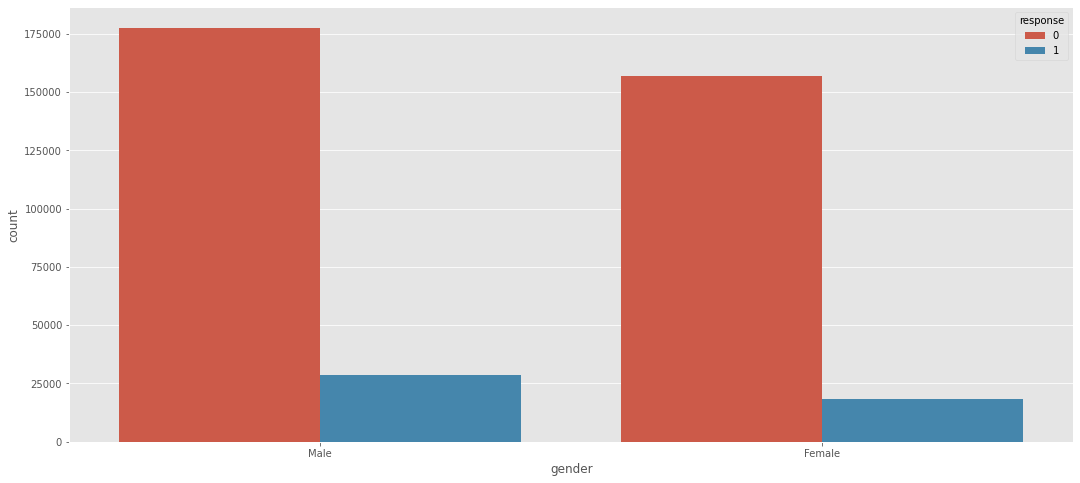

In [28]:
sns.countplot(x='gender', hue='response', data=df5);

### Age

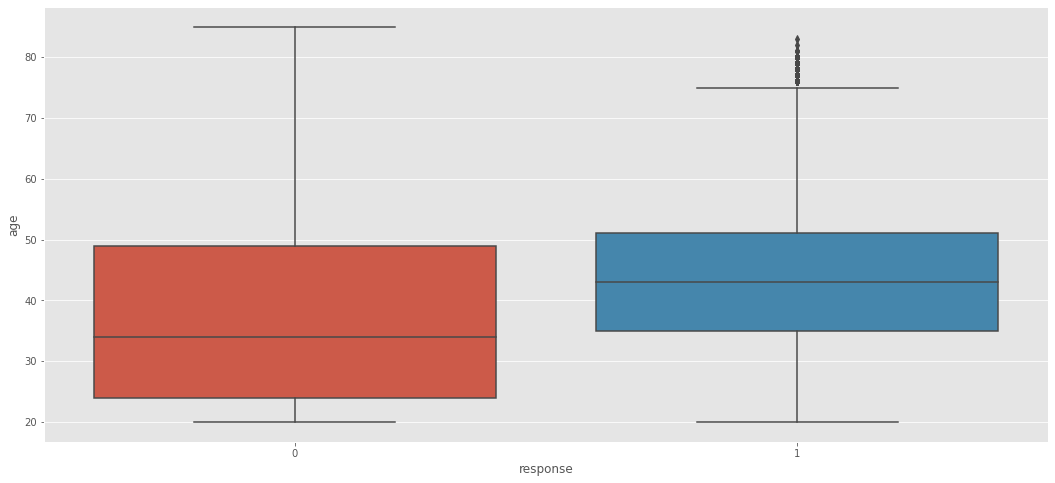

In [29]:
sns.boxplot(x='response', y='age', data=df5);

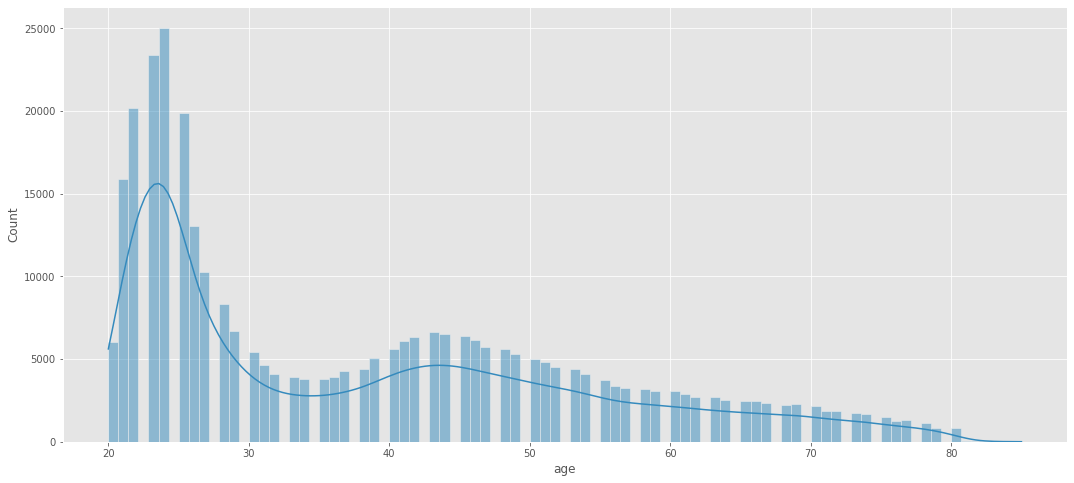

In [30]:
aux = df5.loc[df5['response'] == 0, 'age']
sns.histplot(data=aux, kde=True);

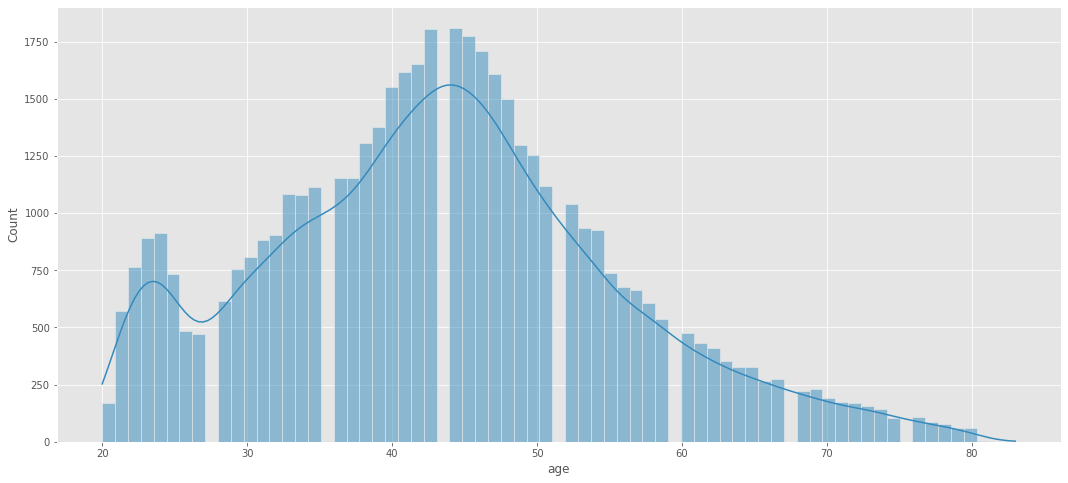

In [31]:
aux = df5.loc[df5['response'] == 1, 'age']
sns.histplot(data=aux, kde=True);

### Driving license

In [32]:
df5[['driving_license', 'response']].value_counts().reset_index().rename(columns={0:'count'})

,driving_license,response,count
0,1,0,333628
1,1,1,46669
2,0,0,771
3,0,1,41


In [33]:
df5[['driving_license', 'response']].value_counts(normalize=True).reset_index().rename(columns={0:'percent'})

,driving_license,response,percent
0,1,0,0.875414
1,1,1,0.122456
2,0,0,0.002023
3,0,1,0.000108


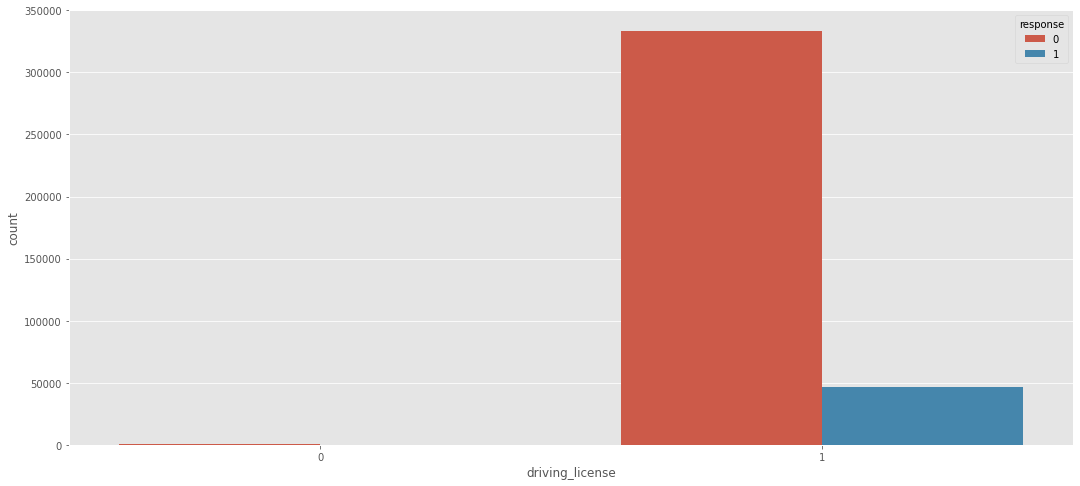

In [34]:
sns.countplot(x='driving_license', hue='response', data=df5);

### Region code

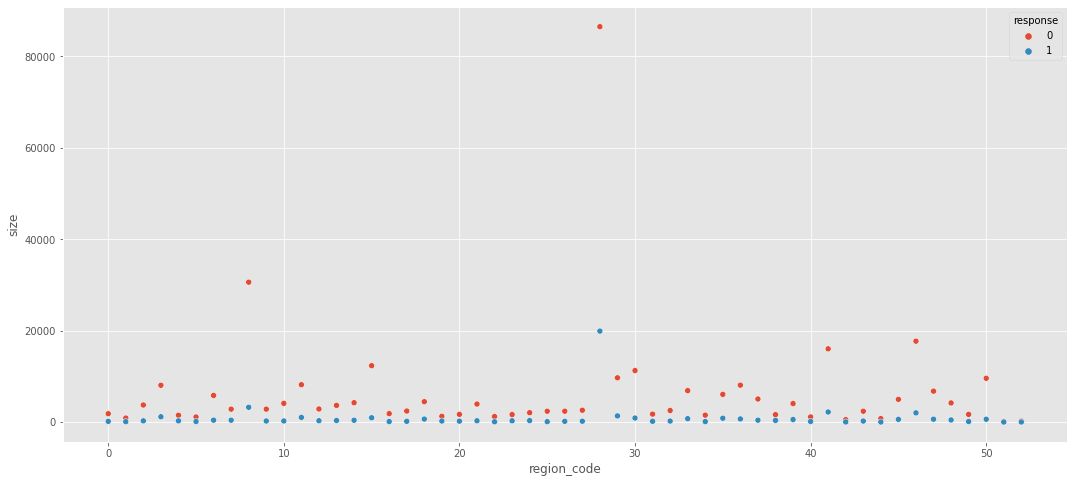

In [35]:
aux = df5.groupby(['region_code', 'response'], as_index=False)['region_code'].size()
sns.scatterplot(x='region_code', y='size', hue='response', data=aux);

### Previously insured

In [36]:
df5[['previously_insured', 'response']].value_counts().reset_index().rename(columns={0:'count'})

,previously_insured,response,count
0,1,0,174470
1,0,0,159929
2,0,1,46552
3,1,1,158


In [37]:
df5[['previously_insured', 'response']].value_counts(normalize=True).reset_index().rename(columns={0:'percent'})

,previously_insured,response,percent
0,1,0,0.457796
1,0,0,0.419641
2,0,1,0.122149
3,1,1,0.000415


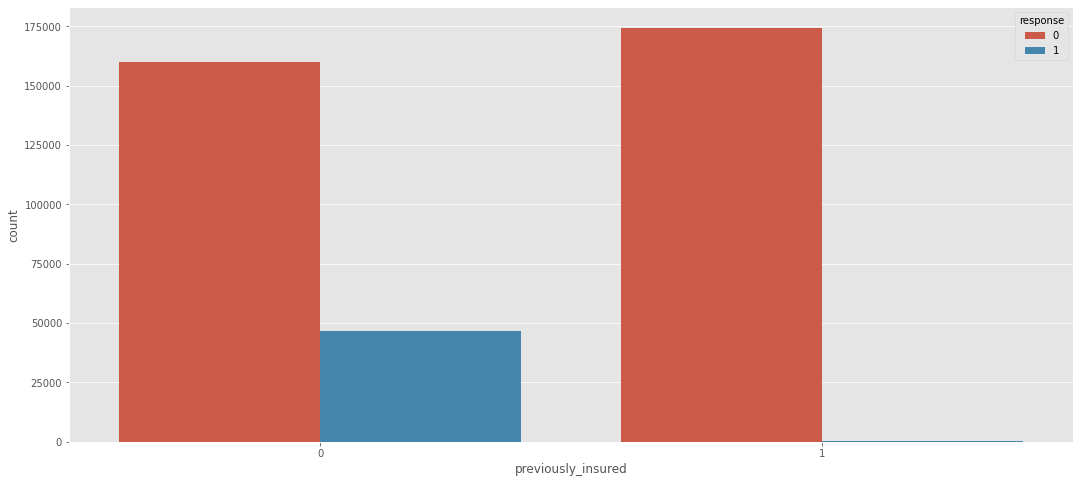

In [38]:
sns.countplot(x='previously_insured', hue='response', data=df5);

### Vehicle age

In [39]:
df5[['vehicle_age', 'response']].value_counts().reset_index().rename(columns={0:'count'})

,vehicle_age,response,count
0,1-2 Year,0,165510
1,< 1 Year,0,157584
2,1-2 Year,1,34806
3,> 2 Years,0,11305
4,< 1 Year,1,7202
5,> 2 Years,1,4702


In [40]:
df5[['vehicle_age', 'response']].value_counts(normalize=True).reset_index().rename(columns={0:'percent'})

,vehicle_age,response,percent
0,1-2 Year,0,0.434285
1,< 1 Year,0,0.413488
2,1-2 Year,1,0.091328
3,> 2 Years,0,0.029663
4,< 1 Year,1,0.018897
5,> 2 Years,1,0.012338


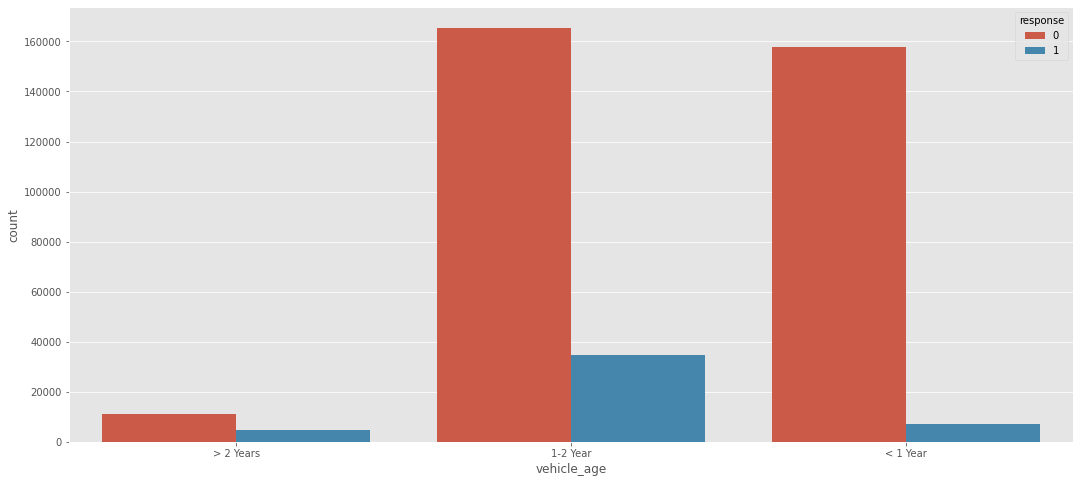

In [41]:
sns.countplot(x='vehicle_age', hue='response', data=df5);

### Vehicle_damage

In [42]:
df5[['vehicle_damage', 'response']].value_counts().reset_index().rename(columns={0:'count'})

,vehicle_damage,response,count
0,No,0,187714
1,Yes,0,146685
2,Yes,1,45728
3,No,1,982


In [43]:
df5[['vehicle_damage', 'response']].value_counts(normalize=True).reset_index().rename(columns={0:'percent'})

,vehicle_damage,response,percent
0,No,0,0.492547
1,Yes,0,0.384890
2,Yes,1,0.119987
3,No,1,0.002577


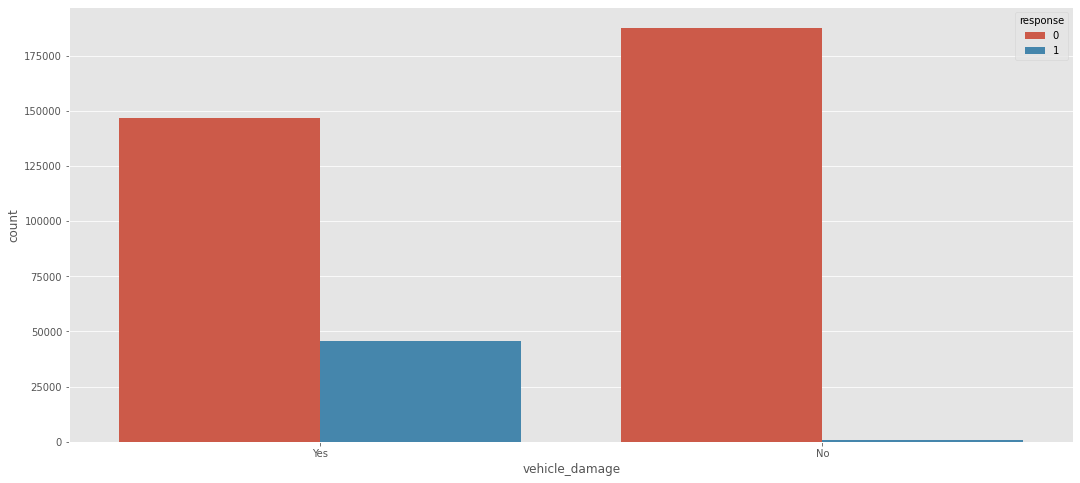

In [44]:
sns.countplot(x='vehicle_damage', hue='response', data=df5);

### Annual premium

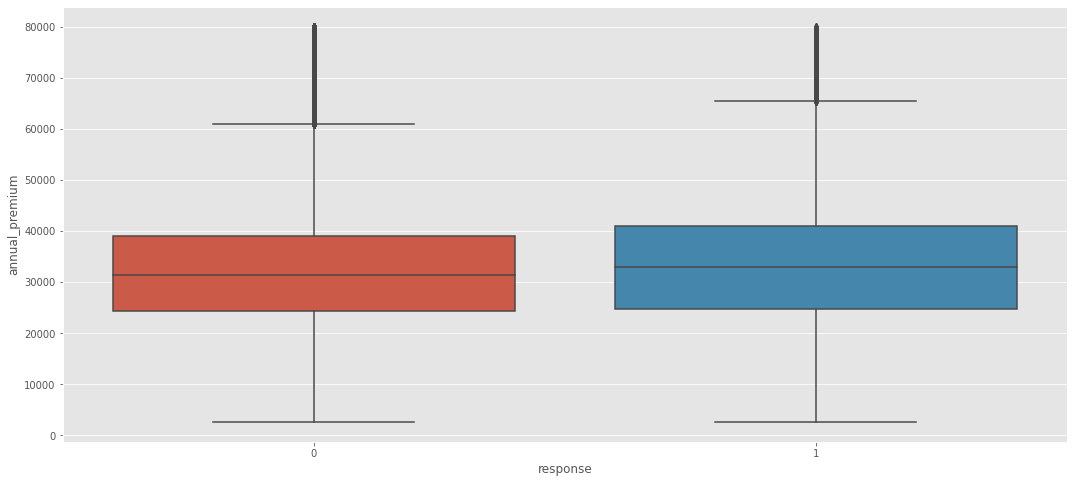

In [45]:
aux = df5[df5['annual_premium'] < 80000]
sns.boxplot(x='response', y='annual_premium', data=aux);

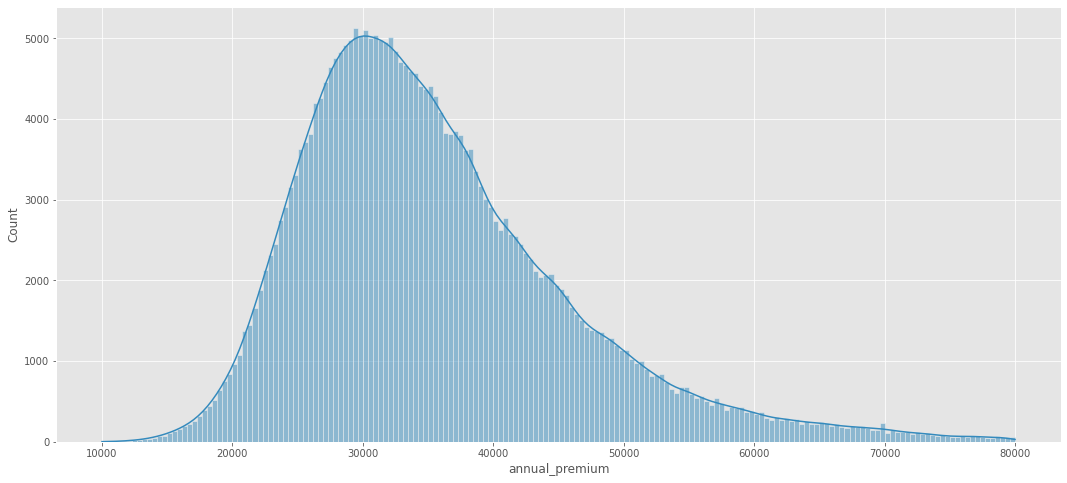

In [46]:
aux = df5[(df5['annual_premium'] > 10000) &(df5['annual_premium'] < 80000)]
aux = aux.loc[aux['response'] == 0, 'annual_premium']
sns.histplot(data=aux, kde=True);

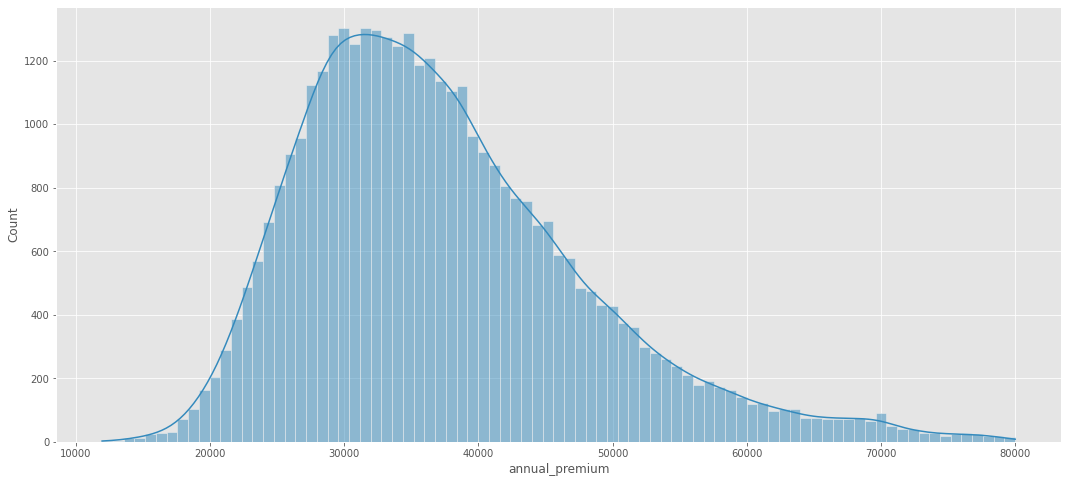

In [47]:
aux = df5[(df5['annual_premium'] > 10000) &(df5['annual_premium'] < 80000)]
aux = aux.loc[aux['response'] == 1, 'annual_premium']
sns.histplot(data=aux, kde=True);

### Policy sales channel

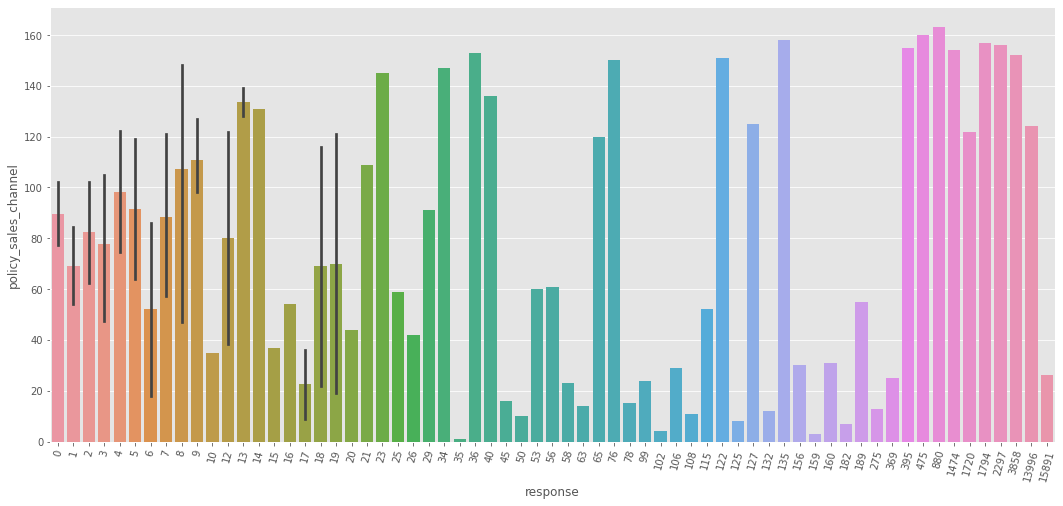

In [48]:
aux = df5[['policy_sales_channel', 'response']].groupby( 'policy_sales_channel').sum().reset_index()
sns.barplot(x='response', y='policy_sales_channel', data=aux)
plt.xticks(rotation=75);

### Vintage

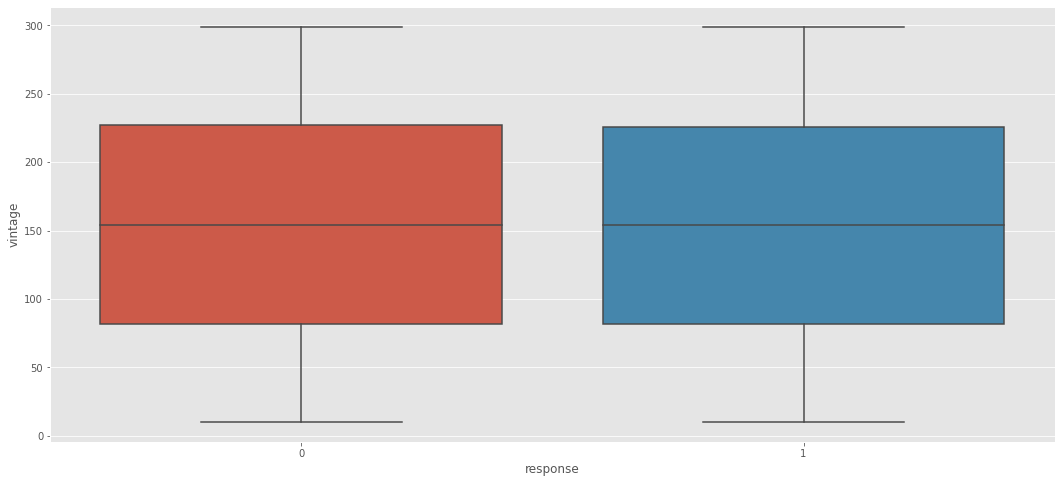

In [49]:
sns.boxplot(x='response', y='vintage', data=df5);

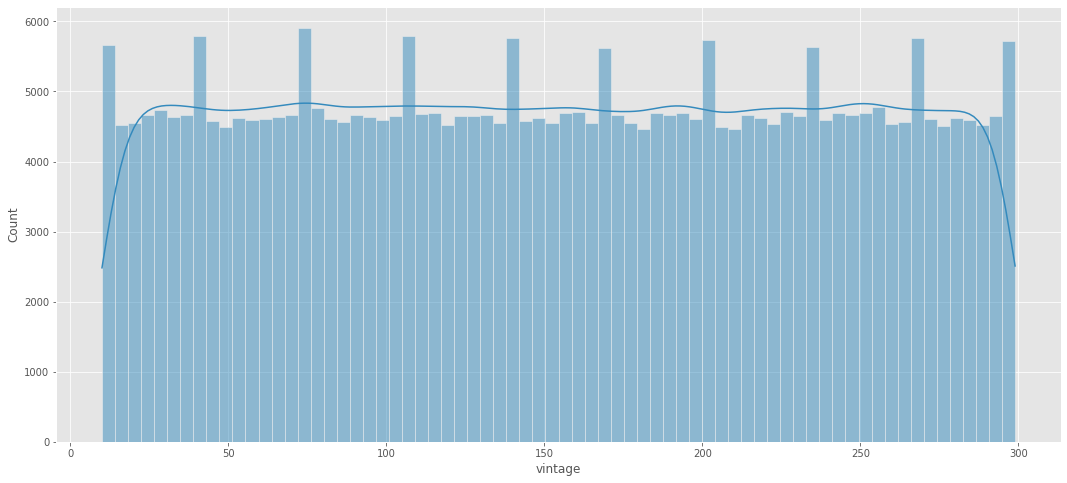

In [50]:
aux = df5.loc[df5['response'] == 0, 'vintage']
sns.histplot(data=aux, kde=True);

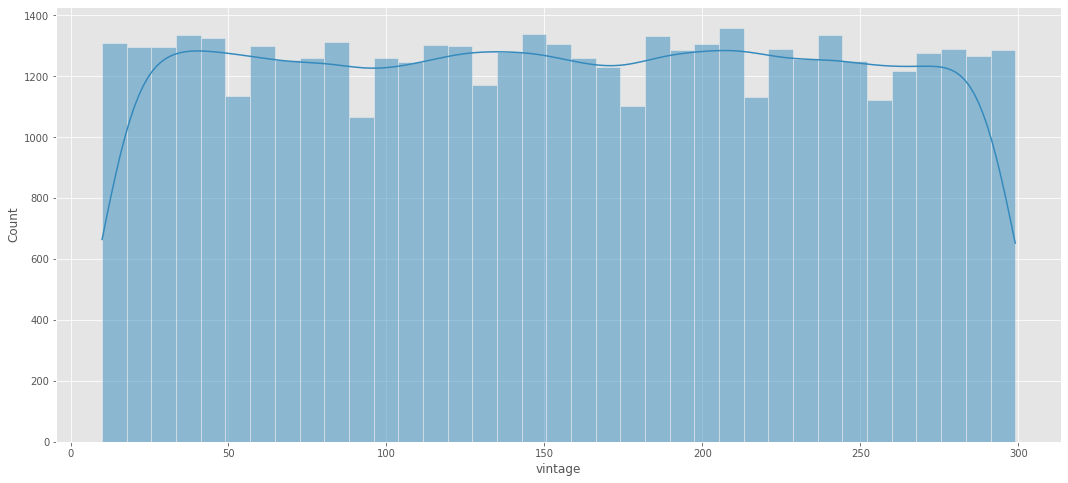

In [51]:
aux = df5.loc[df5['response'] == 1, 'vintage']
sns.histplot(data=aux, kde=True);

## 5.2 - Análise bivariada

### **Hipótese 1 - Homens se acidentam 30% mais que as mulheres.**
Falso, homens se acidentam 17,19% mais.

In [52]:
aux = df5.groupby(['gender', 'vehicle_damage'], as_index=False)['vehicle_damage'].size()
aux = aux[aux['vehicle_damage'] == 'Yes']
aux['percent'] = (aux['size']/aux['size'].sum()) * 100
aux

,gender,vehicle_damage,size,percent
1,Female,Yes,79665,41.403128
3,Male,Yes,112748,58.596872


In [53]:
aux.loc[3, 'percent'] - aux.loc[1, 'percent']

17.193744705399318

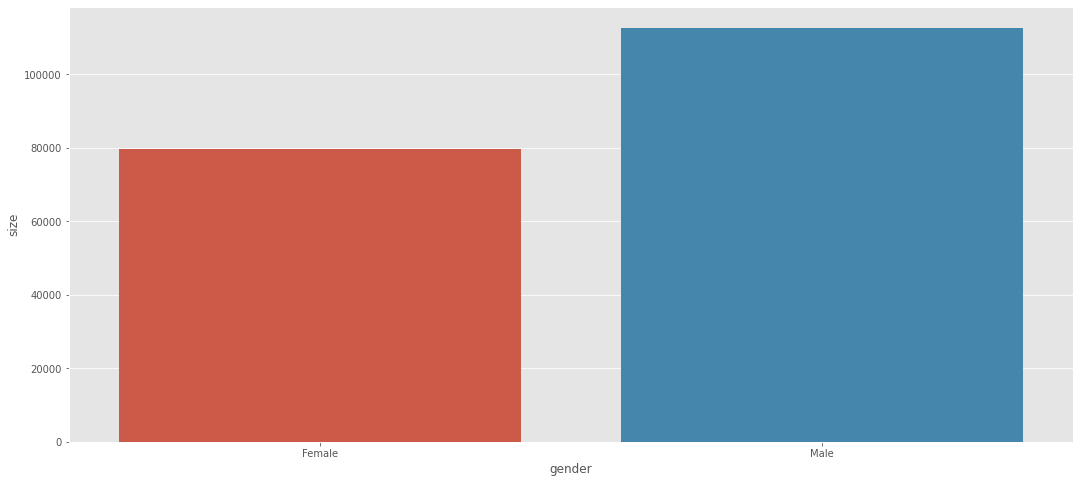

In [54]:
sns.barplot(x='gender', y='size', data=aux);

### **Hipótese 2 - Há 30% mais homens habilitados do que as mulheres.**
Falso, há apenas 8,06% homens a mais que mulheres

In [55]:
aux = df5.groupby(['gender', 'driving_license'], as_index=False)['driving_license'].size()
aux = aux[aux['driving_license'] == 1]
aux['percent'] = (aux['size']/aux['size'].sum()) * 100
aux

,gender,driving_license,size,percent
1,Female,1,174808,45.966179
3,Male,1,205489,54.033821


In [56]:
aux.loc[3, 'percent'] - aux.loc[1, 'percent']

8.067641869381028

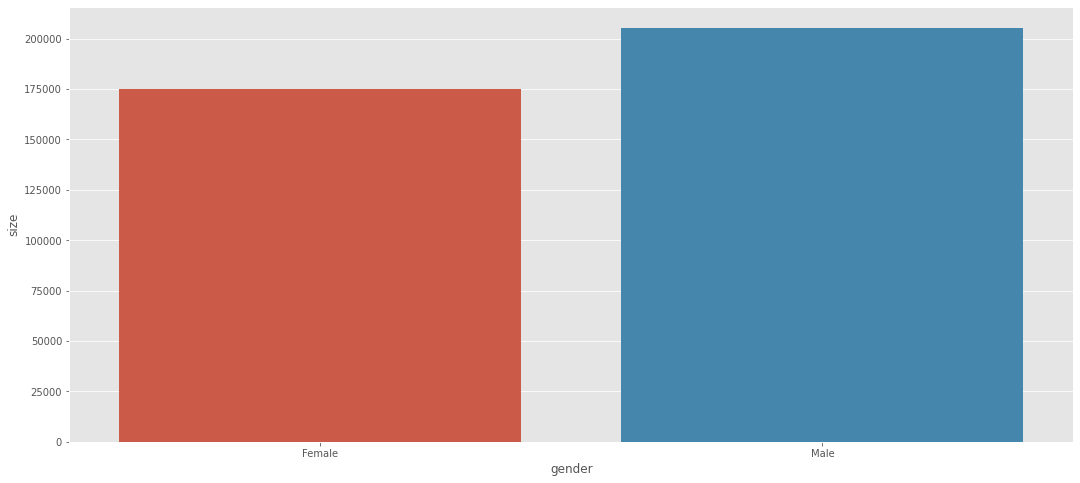

In [57]:
sns.barplot(x='gender', y='size', data=aux);

### **Hipótese 3 - Mais de 50% das mulheres dirigem carros com menos de 1 ano enquanto mais de 50% dos homens dirigem carros com mais antigos.**
Verdadeiro, pois 52,17% das mulheres dirigem veículos abaixo de 1 ano, enquanto apenas 59,35% dos homens dirigem veículos entre 1 e 2 anos e 5% mais de 2 anos.

In [58]:
aux_f = df5.groupby(['gender', 'vehicle_age'], as_index=False)['previously_insured'].size()
aux_f = aux_f[aux_f['gender'] == 'Female']
aux_f['percent'] = (aux_f['size']/aux_f['size'].sum()) * 100
aux_f

,gender,vehicle_age,size,percent
0,Female,1-2 Year,77992,44.561764
1,Female,< 1 Year,91321,52.177465
2,Female,> 2 Years,5707,3.260770


In [59]:
aux_m = df5.groupby(['gender', 'vehicle_age'], as_index=False)['previously_insured'].size()
aux_m = aux_m[aux_m['gender'] == 'Male']
aux_m['percent'] = (aux_m['size']/aux_m['size'].sum()) * 100
aux_m

,gender,vehicle_age,size,percent
3,Male,1-2 Year,122324,59.354939
4,Male,< 1 Year,73465,35.647220
5,Male,> 2 Years,10300,4.997841


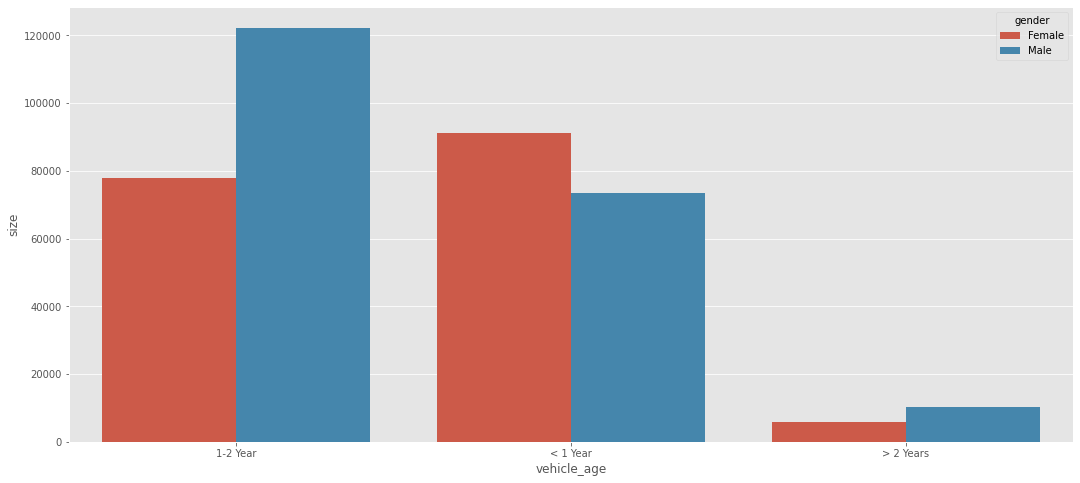

In [60]:
aux = pd.concat([aux_f, aux_m])
sns.barplot(x='vehicle_age', y='size', hue='gender', data=aux);

### Hipótese 4 - Mais de 40% de homens e mulheres possuem seguro veicular.
Verdadeiro, pois 50,25% das mulheres possuem seguro veicular, enquanto apenas 42% do homens possuem.

In [61]:
aux_f = df5.groupby(['gender', 'previously_insured'], as_index=False)['previously_insured'].size()
aux_f = aux_f[aux_f['gender'] == 'Female']
aux_f['percent'] = (aux_f['size']/aux_f['size'].sum()) * 100
aux_f

,gender,previously_insured,size,percent
0,Female,0,87071,49.749172
1,Female,1,87949,50.250828


In [62]:
aux_m = df5.groupby(['gender', 'previously_insured'], as_index=False)['previously_insured'].size()
aux_m = aux_m[aux_m['gender'] == 'Male']
aux_m['percent'] = (aux_m['size']/aux_m['size'].sum()) * 100
aux_m

,gender,previously_insured,size,percent
2,Male,0,119410,57.940987
3,Male,1,86679,42.059013


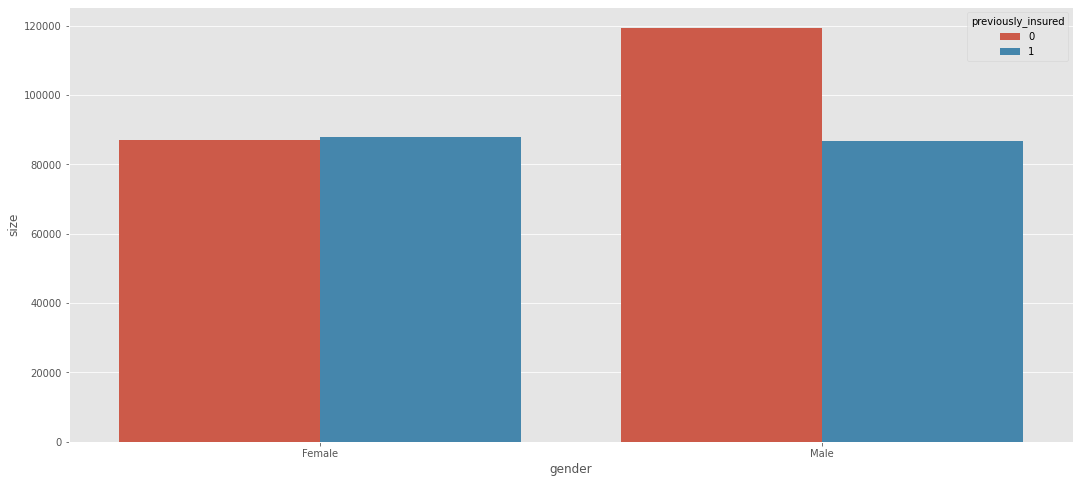

In [63]:
aux = pd.concat([aux_f, aux_m])
sns.barplot(x='gender', y='size', hue='previously_insured', data=aux);

### **Hipótese 5 - Pessoas com menos de 40 anos se acidentam 20% mais.**
Falso, pessoas com menos de 40 anos se acidentam 18,74% menos

In [64]:
aux = df5.copy()
aux['age_40'] = aux['age'].apply(lambda x: 'menor_40' if x < 40 else 'maior_40')

In [65]:
aux1 = aux.groupby(['age_40', 'vehicle_damage'], as_index=False)['vehicle_damage'].size()
aux1 = aux1[aux1['vehicle_damage'] == 'Yes']
aux1['percent'] = (aux1['size']/aux1['size'].sum()) * 100
aux1

,age_40,vehicle_damage,size,percent
1,maior_40,Yes,114239,59.371768
3,menor_40,Yes,78174,40.628232


In [66]:
aux1.loc[1, 'percent'] - aux1.loc[3, 'percent']

18.743536039664676

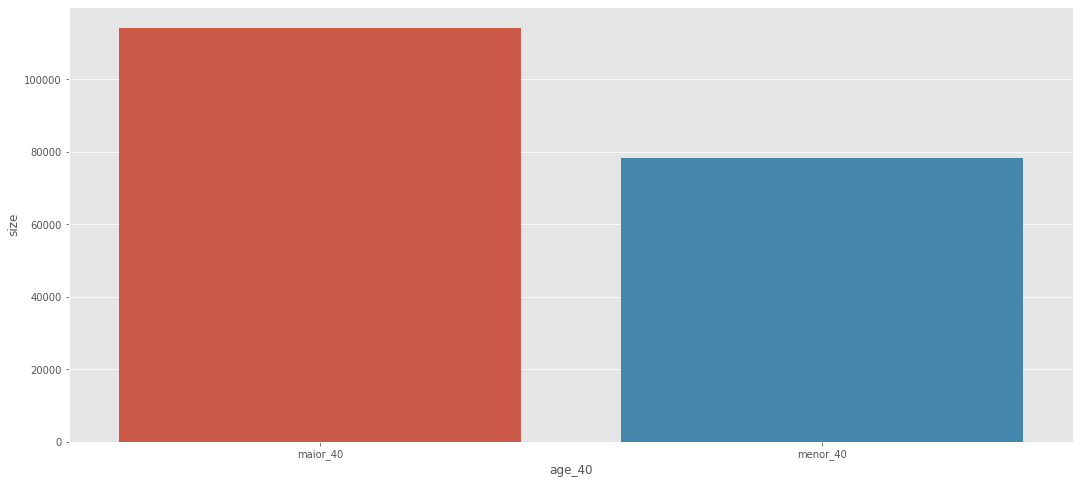

In [67]:
sns.barplot(x='age_40', y='size', data=aux1);

### **Hipótese 6 - Mais de 50% pessoas com menos de 40 anos dirigem carros mais novos (com menos de 1 ano), enquanto mais de 40% da pessoas com mais de 40 dirigem carros mais antigos.**
Verdadeiro, pois 78,36% das pessoas com menos de 40 anos dirigem veículos com menos de 1 ano, enquanto pessoas com mais de 40 anos dirigem 90% veículos entre 1 e 2 anos e 8,74 veículos com mais de 2 anos.

In [68]:
aux = df5.copy()
aux['age_40'] = aux['age'].apply(lambda x: 'menor_40' if x < 40 else 'maior_40')

In [69]:
aux1 = aux.groupby(['age_40', 'vehicle_age'], as_index=False)['vehicle_age'].size()
aux1 = aux1[aux1['age_40'] == 'menor_40']
aux1['percent'] = (aux1['size']/aux1['size'].sum()) * 100
aux1

,age_40,vehicle_age,size,percent
3,menor_40,1-2 Year,44332,21.165304
4,menor_40,< 1 Year,164130,78.360133
5,menor_40,> 2 Years,994,0.474563


In [70]:
aux2 = aux.groupby(['age_40', 'vehicle_age'], as_index=False)['vehicle_age'].size()
aux2 = aux2[aux2['age_40'] == 'maior_40']
aux2['percent'] = (aux2['size']/aux2['size'].sum()) * 100
aux2

,age_40,vehicle_age,size,percent
0,maior_40,1-2 Year,155984,90.871700
1,maior_40,< 1 Year,656,0.382166
2,maior_40,> 2 Years,15013,8.746133


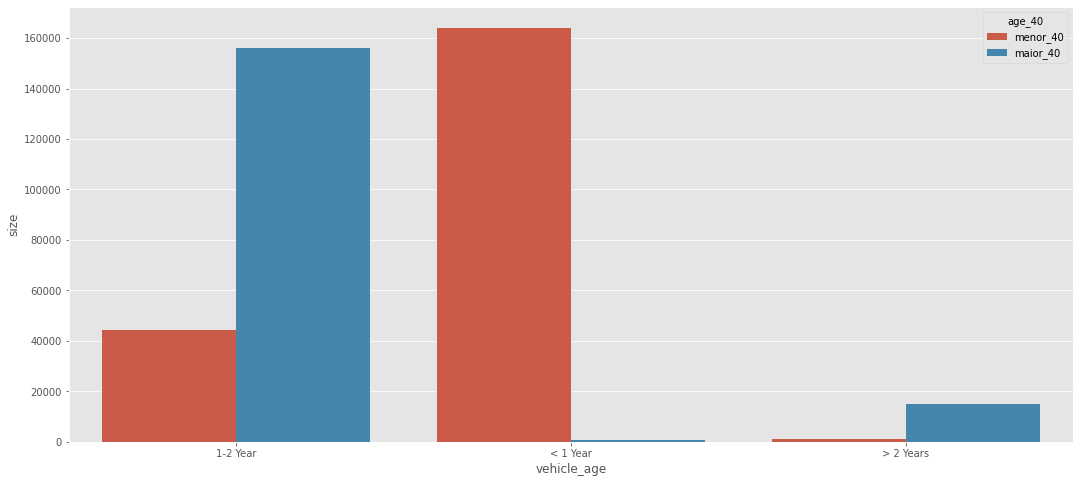

In [71]:
aux = pd.concat([aux1, aux2])
sns.barplot(x='vehicle_age', y='size', hue='age_40', data=aux);

### **Hipótese 7 - Menos de 40% das pessoas com menos de 40 anos dirigem sem seguro no veículo, enquanto mais de 70% das pessoas com mais de 40 anos possuem seguro.**
Falso, pois 41,53% das pessoas com menos de 40 anos não possuem seguro, 69,6% das pessoas com mais de 40 anos não possuem.

In [72]:
aux = df5.copy()
aux['age_40'] = aux['age'].apply(lambda x: 'menor_40' if x < 40 else 'maior_40')

In [73]:
aux1 = aux.groupby(['age_40', 'previously_insured'], as_index=False)['previously_insured'].size()
aux1 = aux1[aux1['age_40'] == 'menor_40']
aux1['percent'] = (aux1['size']/aux1['size'].sum()) * 100
aux1

,age_40,previously_insured,size,percent
2,menor_40,0,86999,41.535692
3,menor_40,1,122457,58.464308


In [74]:
aux2 = aux.groupby(['age_40', 'previously_insured'], as_index=False)['previously_insured'].size()
aux2 = aux2[aux2['age_40'] == 'maior_40']
aux2['percent'] = (aux2['size']/aux2['size'].sum()) * 100
aux2

,age_40,previously_insured,size,percent
0,maior_40,0,119482,69.606707
1,maior_40,1,52171,30.393293


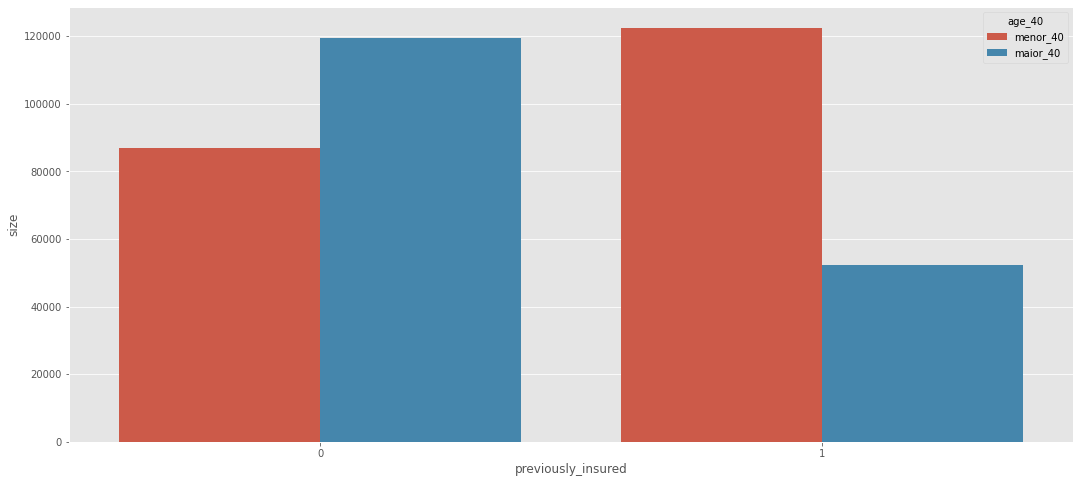

In [75]:
aux = pd.concat([aux1, aux2])
sns.barplot(x='previously_insured', y='size', hue='age_40', data=aux);

## 5.2.1 - Resumo das hipóteses

In [138]:
tab =[['Hipoteses', 'Conclusao', 'Relevancia'],
['H1', 'Falsa', 'Baixa'],
['H2', 'Falsa', 'Baixa'],
['H3', 'Verdadeira', 'Média'],
['H4', 'Verdadeira', 'Alta'],
['H5', 'Falsa', 'Alta'],
['H6', 'Verdadeira', 'Média'],
['H7', 'Falsa', 'Alta']
]
print( tabulate( tab, headers='firstrow' ) )

Hipoteses    Conclusao    Relevancia
-----------  -----------  ------------
H1           Falsa        Baixa
H2           Falsa        Baixa
H3           Verdadeira   Média
H4           Verdadeira   Alta
H5           Falsa        Alta
H6           Verdadeira   Média
H7           Falsa        Alta


## 5.3 - Análise multivariada

### 5.3.1 - Análise numérica

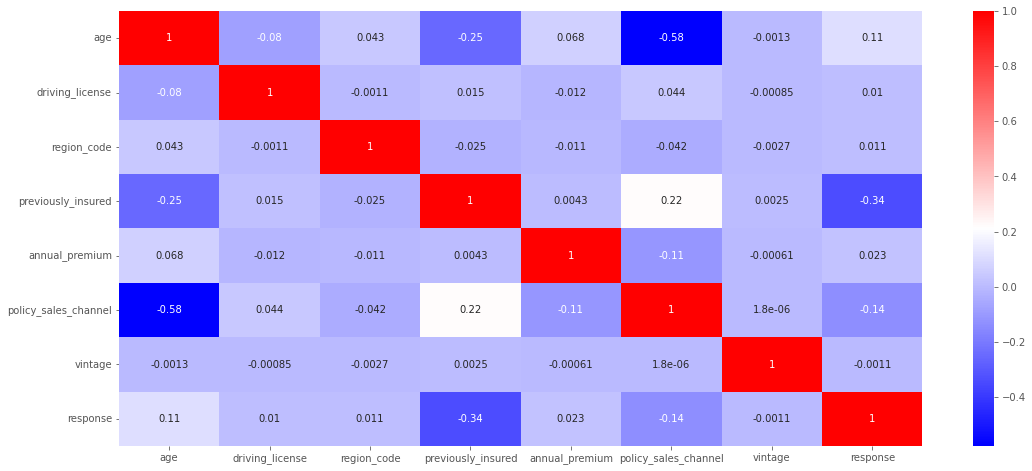

In [76]:
# Método de pearson
correlacao = num.drop('id', axis=1).corr()
sns.heatmap(correlacao, annot=True, cmap='bwr');

### 5.3.2 - Análise categórica

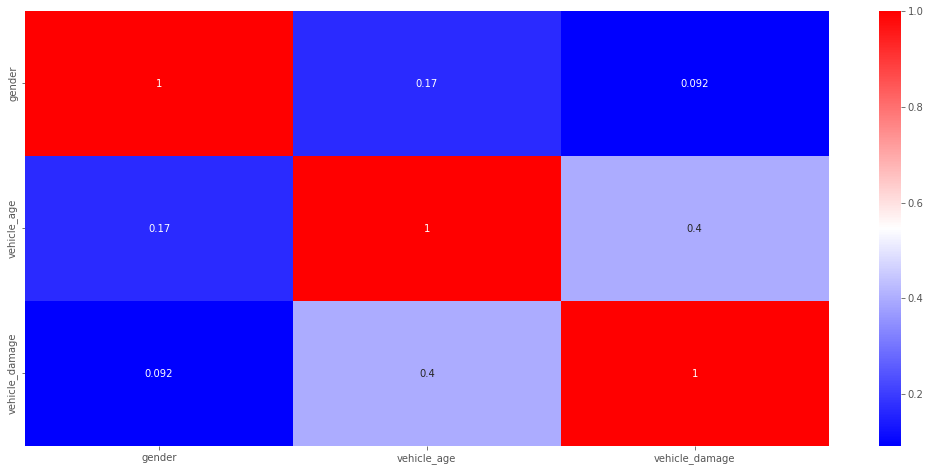

In [77]:
# Método de Cramer
correlacao = corr_matrix(cat, cat.columns)
sns.heatmap(correlacao, annot=True, cmap='bwr');

# 6 - Preparação dos dados

In [78]:
df6 = df5.copy()

## 6.1 - Separação do dataframe entre treino e teste

In [79]:
# Separando os dados de entrada e o alvo
X = df6.drop(['id', 'response'], axis=1)
y = df6['response']

# Separando os dados de treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f'Tamanho do X_train: {X_train.shape} e y_train:{y_train.shape}')
print(f'Tamanho do X_test: {X_test.shape} e y_test:{y_test.shape}')

Tamanho do X_train: (304887, 10) e y_train:(304887,)
Tamanho do X_test: (76222, 10) e y_test:(76222,)


## 6.2 - Normalização

In [80]:
ss_annual_premium = StandardScaler()

# -------------------- Treino --------------------
X_train['annual_premium'] = ss_annual_premium.fit_transform(X_train[['annual_premium']])
joblib.dump(ss_annual_premium, '../src/features/ss_annual_premium.joblib')

# -------------------- Teste --------------------
X_test['annual_premium'] = ss_annual_premium.transform(X_test[['annual_premium']])

## 6.3 - Rescaling

In [81]:
mms_age = MinMaxScaler()
mms_vintage = MinMaxScaler()

# -------------------- Treino --------------------
X_train['age'] = mms_age.fit_transform(X_train[['age']])
joblib.dump(mms_age, '../src/features/mms_age.joblib')

X_train['age'] = mms_vintage.fit_transform(X_train[['age']])
joblib.dump(mms_vintage, '../src/features/mms_vintage.joblib')

# -------------------- Teste --------------------
X_test['vintage'] = mms_age.transform(X_test[['vintage']])
X_test['vintage'] = mms_vintage.transform(X_test[['vintage']])

## 6.4 - Transformação

### 6.4.1 - Encoding

In [82]:
target_encode_gender = df5.groupby( 'gender' )['response'].mean()
target_encode_region_code = df5.groupby( 'region_code' )['response'].mean()
fe_policy_sales_channel = df5.groupby( 'policy_sales_channel' ).size() / len( df6 ) 

# -------------------- Treino --------------------
X_train['vehicle_damage'] = X_train['vehicle_damage'].apply(lambda x: 0 if x == 'No' else 1)
X_train = pd.get_dummies( X_train, prefix='vehicle_age', columns=['vehicle_age'] )

X_train.loc[:, 'gender'] = X_train['gender'].map( target_encode_gender )
joblib.dump(target_encode_gender, '../src/features/target_encode_gender.joblib')

X_train.loc[:, 'region_code'] = X_train['region_code'].map( target_encode_region_code )
joblib.dump(target_encode_region_code, '../src/features/target_encode_region_code.joblib')

X_train.loc[:, 'policy_sales_channel'] = X_train['policy_sales_channel'].map( fe_policy_sales_channel )
joblib.dump(fe_policy_sales_channel, '../src/features/fe_policy_sales_channel.joblib')

# -------------------- Teste --------------------
X_test['vehicle_damage'] = X_test['vehicle_damage'].apply(lambda x: 0 if x == 'No' else 1)
X_test = pd.get_dummies( X_test, prefix='vehicle_age', columns=['vehicle_age'] )
X_test.loc[:, 'gender'] = X_test['gender'].map( target_encode_gender )
X_test.loc[:, 'region_code'] = X_test['region_code'].map( target_encode_region_code )
X_test.loc[:, 'policy_sales_channel'] = X_test['policy_sales_channel'].map( fe_policy_sales_channel )

### 6.4.2 - Transformação da variável resposta

### 6.4.3 - Transformação de natureza

# 7 - Seleção de features

## 7.1 - Excluir colunas para a seleção

## 7.2 - Seleção de features

In [83]:
# model definition
forest = ExtraTreesClassifier( n_estimators=250, random_state=0, n_jobs=-1 )

# data preparation
forest.fit(X_train, y_train)

ExtraTreesClassifier(n_estimators=250, n_jobs=-1, random_state=0)

Feature ranking:
                 feature  importance
0                vintage    0.274032
0         annual_premium    0.245628
0                    age    0.164759
0            region_code    0.105192
0         vehicle_damage    0.069193
0   policy_sales_channel    0.059658
0     previously_insured    0.054106
0   vehicle_age_< 1 Year    0.013579
0   vehicle_age_1-2 Year    0.006200
0                 gender    0.004939
0  vehicle_age_> 2 Years    0.002220
0        driving_license    0.000495


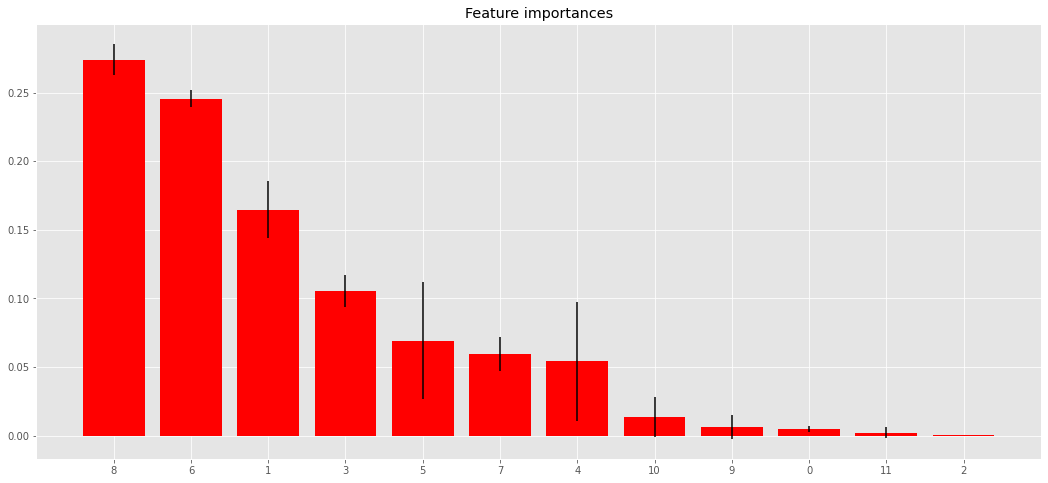

In [84]:
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_], axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")
df = pd.DataFrame()
for i, j in zip( X_train, forest.feature_importances_ ):
    aux = pd.DataFrame( {'feature': i, 'importance': j}, index=[0] )
    df = pd.concat( [df, aux], axis=0 )
    
print( df.sort_values( 'importance', ascending=False ) )

# Plot the impurity-based feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(X_train.shape[1]), importances[indices], color="r", yerr=std[indices], align="center")
plt.xticks(range(X_train.shape[1]), indices)
plt.xlim([-1, X_train.shape[1]])
plt.show()

## 7.3 - Seleção manual das features

In [85]:
cols_selected = ['vintage', 'annual_premium', 'age', 'region_code', 'vehicle_damage', 'policy_sales_channel', 'previously_insured']

In [86]:
X_train_fs = X_train[cols_selected]
X_test_fs = X_test[cols_selected]

y_train_fs = y_train.copy()
y_test_fs = y_test.copy()

# 8 - Modelos de Machine Learning

## 8.1 - Modelo Logistic Regression

In [87]:
# Modelo
lr_model = LogisticRegression()

# Treinando o modelo
lr_model.fit(X_train_fs, y_train_fs)

# Predição do modelo
y_pred_lr = lr_model.predict_proba(X_test_fs)

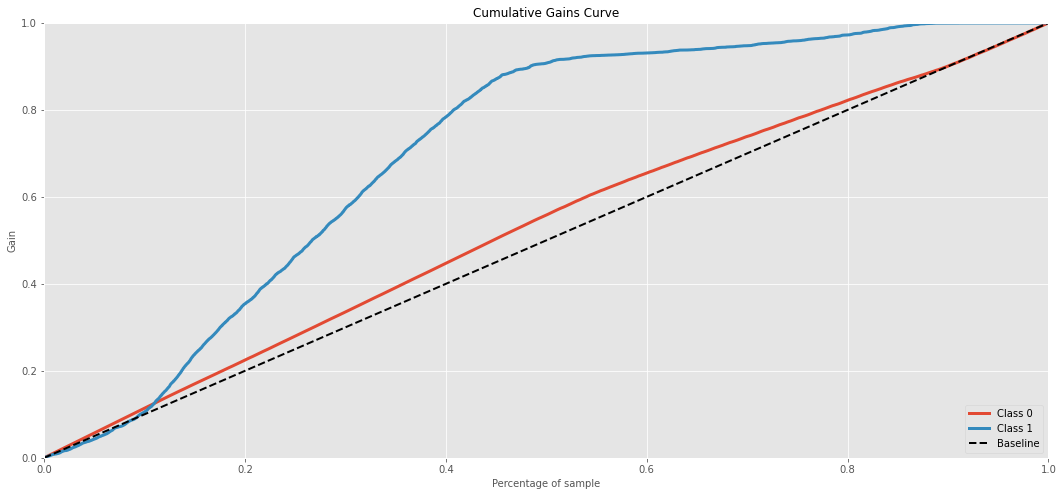

In [88]:
# Curva de ganho cumulativo
skplt.metrics.plot_cumulative_gain(y_test_fs, y_pred_lr);

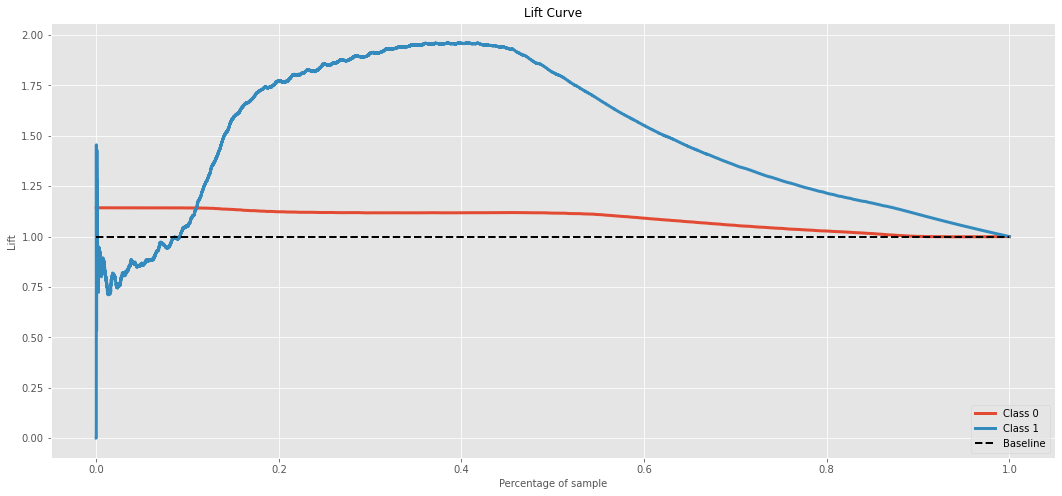

In [89]:
#Curva LIFT
skplt.metrics.plot_lift_curve(y_test_fs, y_pred_lr);

In [90]:
df8 = X_test.copy()
df8['response'] = y_test.copy()

precision_k = precision(df8, y_pred_lr, 0.3)
print(f'A precisão top K é: {round(precision_k, 2)}')

recall_k = recall(df8, y_pred_lr, 0.3)
print(f'O recall top K é: {round(recall_k, 2)}')

A precisão top K é: 0.24
O recall top K é: 0.57


In [91]:
df_lr = cross_validation('Logistic Regression', lr_model, 3, X_train_fs, y_train_fs, 0.3)
df_lr

,model_name,Precision,Recall
0,Logistic Regression,mean: 0.27 | std: +/- 0.01,mean: 0.67 | std: +/- 0.02


## 8.2 - KNN

In [92]:
# Modelo
knn_model = KNeighborsClassifier()

# Treinando o modelo
knn_model.fit(X_train_fs, y_train_fs)

# Predição do modelo
y_pred_knn = knn_model.predict_proba(X_test_fs)

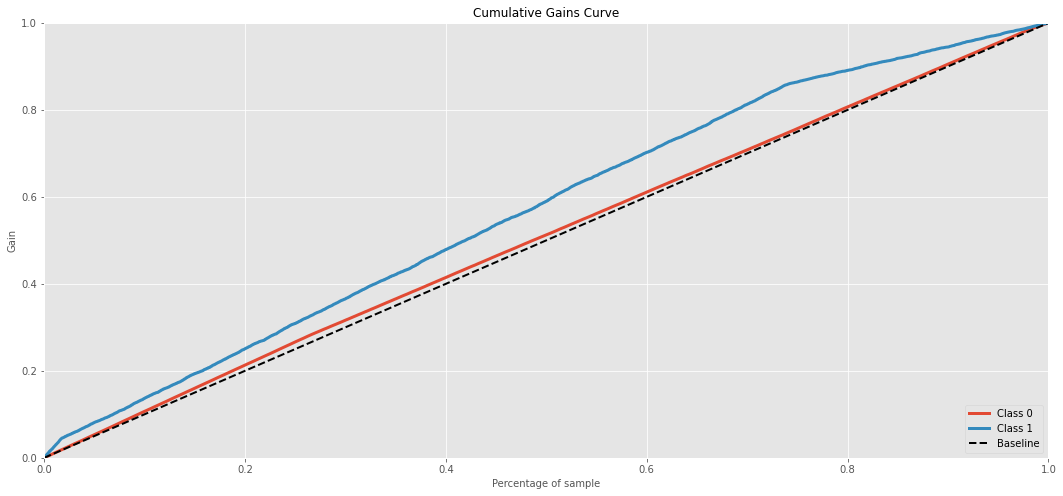

In [93]:
# Curva de ganho cumulativo
skplt.metrics.plot_cumulative_gain(y_test_fs, y_pred_knn);

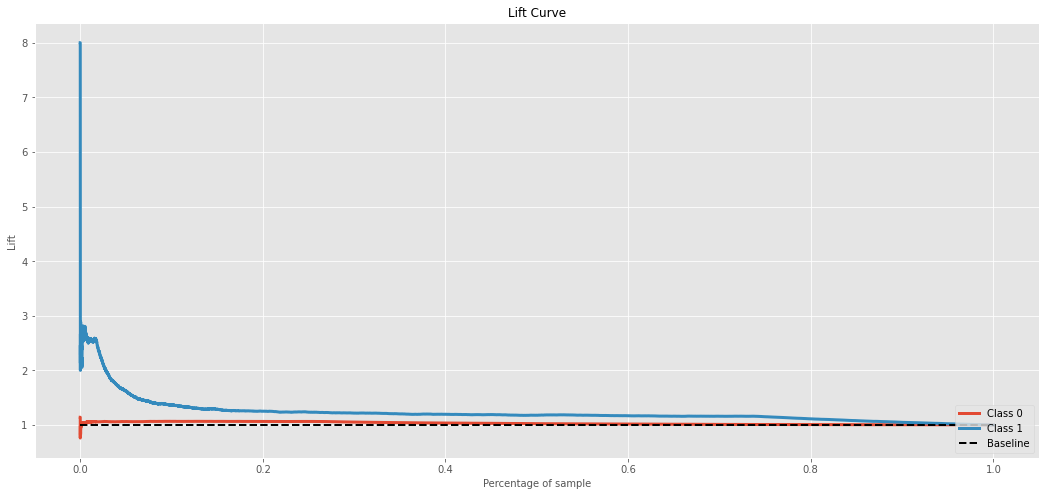

In [94]:
#Curva LIFT
skplt.metrics.plot_lift_curve(y_test_fs, y_pred_knn);

In [95]:
df8 = X_test.copy()
df8['response'] = y_test.copy()

precision_k = precision(df8, y_pred_knn, 0.3)
print(f'A precisão top K é: {precision_k}')

recall_k = recall(df8, y_pred_knn, 0.3)
print(f'O recall top K é: {recall_k}')

A precisão top K é: 0.14833603008702498
O recall top K é: 0.35619027617347476


In [96]:
df_knn = cross_validation('KNN', knn_model, 3, X_train_fs, y_train_fs, 0.3)
df_knn

,model_name,Precision,Recall
0,KNN,mean: 0.26 | std: +/- 0.0,mean: 0.64 | std: +/- 0.01


## 8.3 - Random Forest

In [97]:
# Modelo
rf_model = RandomForestClassifier()

# Treinando o modelo
rf_model.fit(X_train_fs, y_train_fs)

# Predição do modelo
y_pred_rf = rf_model.predict_proba(X_test_fs)

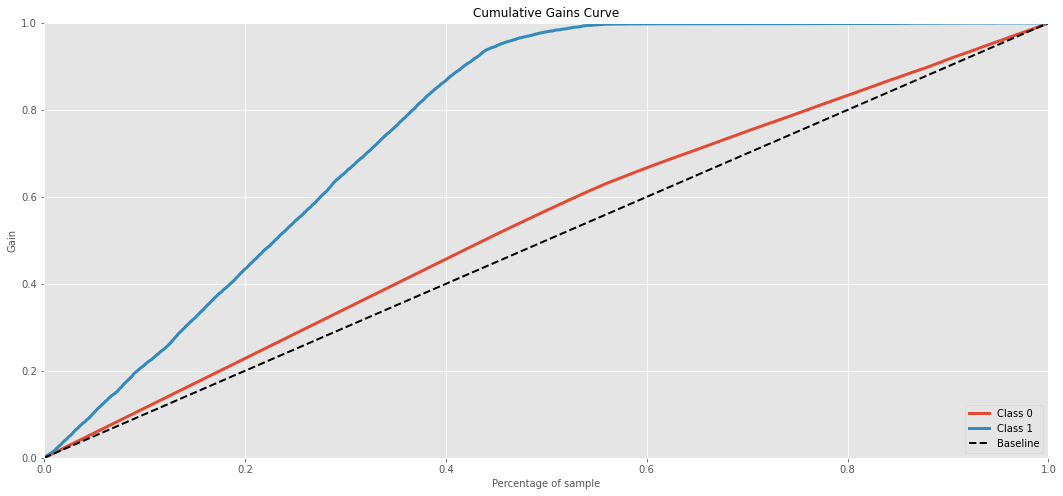

In [98]:
# Curva de ganho cumulativo
skplt.metrics.plot_cumulative_gain(y_test_fs, y_pred_rf);

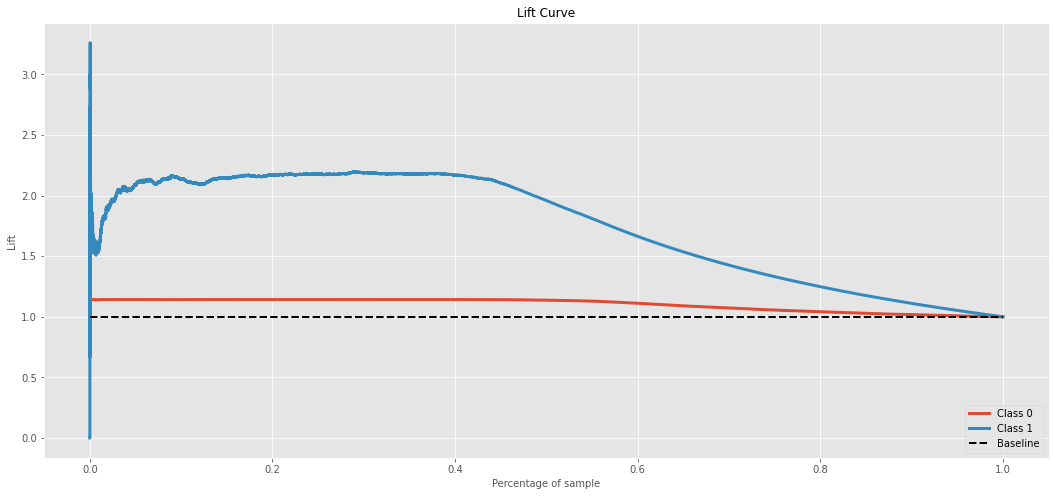

In [99]:
#Curva LIFT
skplt.metrics.plot_lift_curve(y_test_fs, y_pred_rf);

In [100]:
df8 = X_test.copy()
df8['response'] = y_test.copy()

precision_k = precision(df8, y_pred_rf, 0.3)
print(f'A precisão top K é: {precision_k}')

recall_k = recall(df8, y_pred_rf, 0.3)
print(f'O recall top K é: {recall_k}')

A precisão top K é: 0.27314470634538857
O recall top K é: 0.6558857502887745


In [101]:
df_rf = cross_validation('Random Forest', rf_model, 3, X_train_fs, y_train_fs, 0.3)
df_rf

,model_name,Precision,Recall
0,Random Forest,mean: 0.3 | std: +/- 0.0,mean: 0.73 | std: +/- 0.0


## 8.4 - Extra Tree

In [102]:
# Modelo
et_model = RandomForestClassifier()

# Treinando o modelo
et_model.fit(X_train_fs, y_train_fs)

# Predição do modelo
y_pred_et = et_model.predict_proba(X_test_fs)

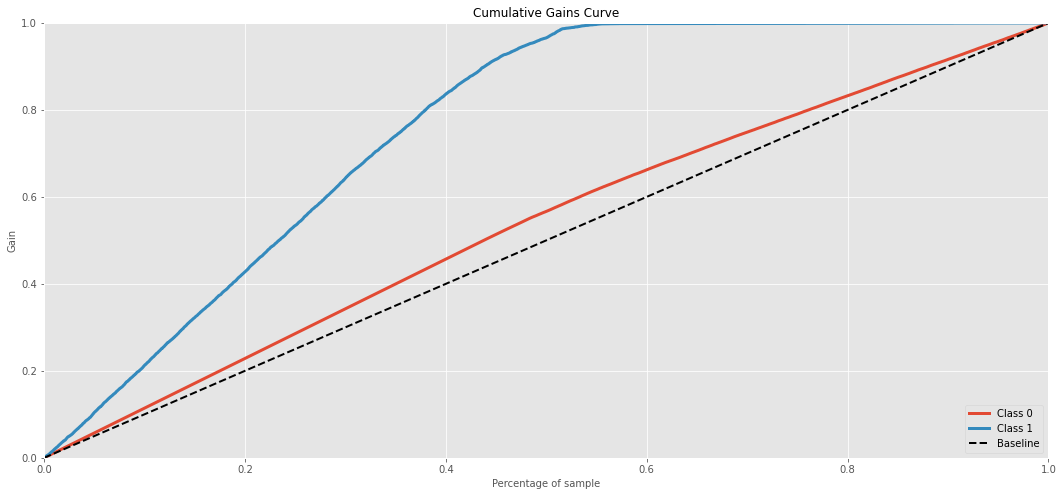

In [103]:
# Curva de ganho cumulativo
skplt.metrics.plot_cumulative_gain(y_test_fs, y_pred_et);

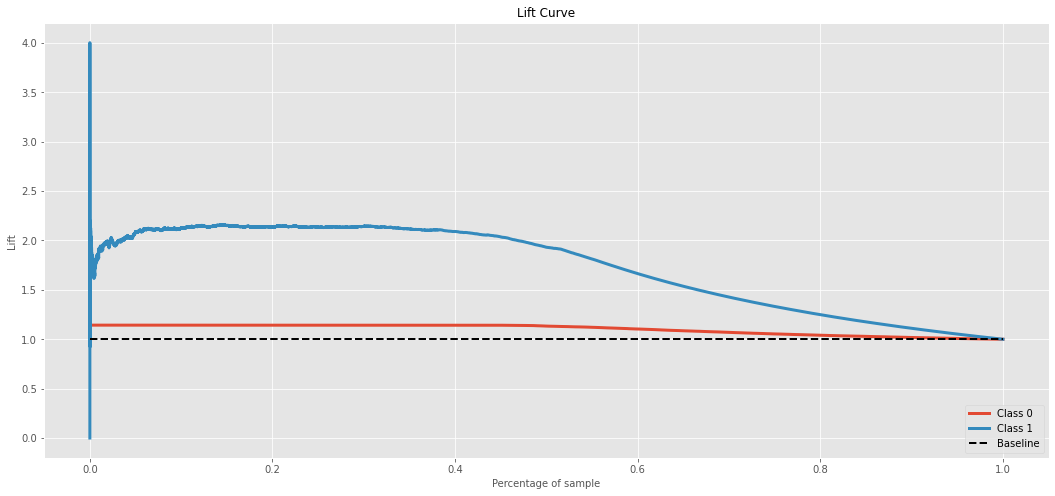

In [104]:
#Curva LIFT
skplt.metrics.plot_lift_curve(y_test_fs, y_pred_et);

In [105]:
df8 = X_test.copy()
df8['response'] = y_test.copy()

precision_k = precision(df8, y_pred_et, 0.3)
print(f'A precisão top K é: {precision_k}')

recall_k = recall(df8, y_pred_et, 0.3)
print(f'O recall top K é: {recall_k}')

A precisão top K é: 0.26715354003585956
O recall top K é: 0.6414995274598341


In [106]:
df_et = cross_validation('Extra Tree', et_model, 3, X_train_fs, y_train_fs, 0.3)
df_et

,model_name,Precision,Recall
0,Extra Tree,mean: 0.3 | std: +/- 0.0,mean: 0.73 | std: +/- 0.0


## 8.5 - XGBoost

In [130]:
# Modelo
xgb_model = XGBClassifier()

# Treinando o modelo
xgb_model.fit(X_train_fs, y_train_fs)

# Predição do modelo
y_pred_xgb = xgb_model.predict_proba(X_test_fs)

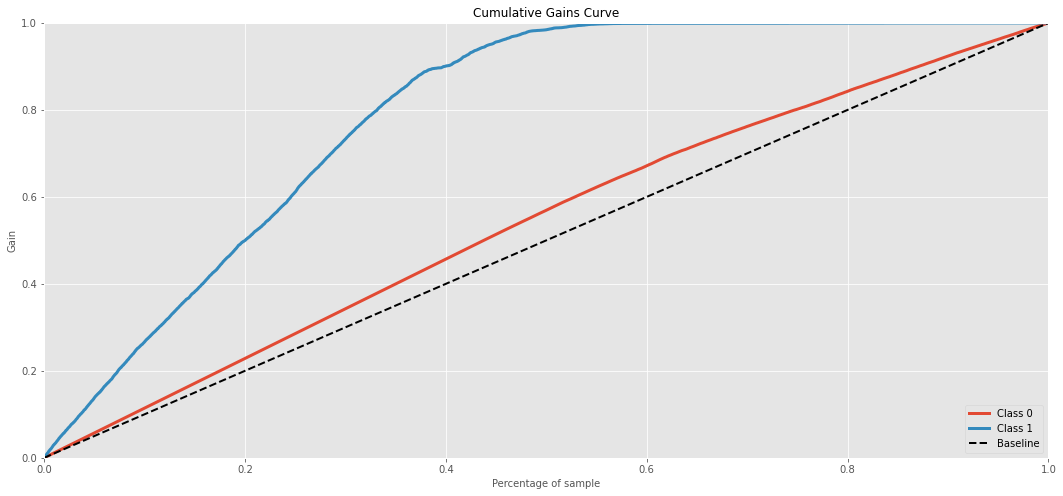

In [131]:
# Curva de ganho cumulativo
skplt.metrics.plot_cumulative_gain(y_test_fs, y_pred_xgb);

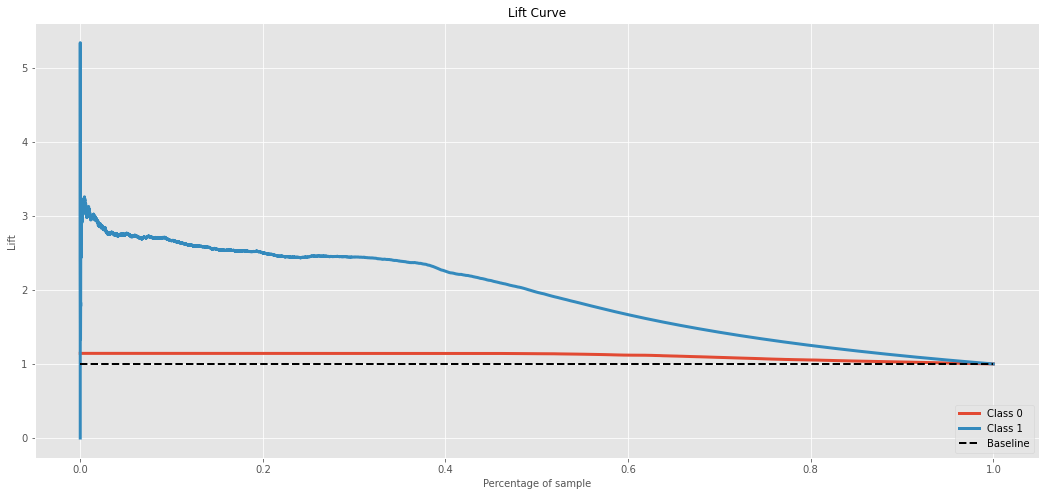

In [132]:
#Curva LIFT
skplt.metrics.plot_lift_curve(y_test_fs, y_pred_xgb);

In [133]:
df8 = X_test.copy()
df8['response'] = y_test.copy()

precision_k = precision(df8, y_pred_xgb, 0.3)
print(f'A precisão top K é: {precision_k}')

recall_k = recall(df8, y_pred_xgb, 0.3)
print(f'O recall top K é: {recall_k}')

A precisão top K é: 0.3058555997725981
O recall top K é: 0.7344324267562743


In [134]:
df_xgb = cross_validation('XGBoost', xgb_model, 3, X_train_fs, y_train_fs, 0.3)
df_xgb

,model_name,Precision,Recall
0,XGBoost,mean: 0.32 | std: +/- 0.0,mean: 0.78 | std: +/- 0.01


## 8.6 - Avaliação final

In [115]:
resultado_cv = pd.concat([df_lr, df_knn, df_rf, df_et, df_xgb])
resultado_cv.sort_values(['Precision', 'Recall'], ascending=False)

,model_name,Precision,Recall
0,XGBoost,mean: 0.32 | std: +/- 0.0,mean: 0.78 | std: +/- 0.01
0,Random Forest,mean: 0.3 | std: +/- 0.0,mean: 0.73 | std: +/- 0.0
0,Extra Tree,mean: 0.3 | std: +/- 0.0,mean: 0.73 | std: +/- 0.0
0,Logistic Regression,mean: 0.27 | std: +/- 0.01,mean: 0.67 | std: +/- 0.02
0,KNN,mean: 0.26 | std: +/- 0.0,mean: 0.64 | std: +/- 0.01


# 9 - Fine Tunning

## 9.1 - Random Search

In [123]:
param = {
'n_estimators': [550, 600, 700, 850, 1000],
'eta': [0.01, 0.03],
'max_depth': [3, 5, 10, 15],
'subsample': [0.1, 0.5, 0.7, 1],
'colsample_bytree': [0.3, 0.7, 0.9, 1],
'min_child_weight': [1, 3, 8, 15]
}

max_eval = 3

In [124]:
resultado_final = pd.DataFrame()

for i in range(max_eval):
    hp = { k: random.sample( v, 1 )[0] for k, v in param.items() }
    print(hp)

    # modelo
    xgb_model_tunned = XGBClassifier(n_estimators=hp['n_estimators'],
    eta=hp['eta'],
    max_depth=hp['max_depth'],
    subsample=hp['subsample'],
    colsample_bytree=hp['colsample_bytree'],
    min_child_weight=hp['min_child_weight'] )

    # perfomance
    resultado_xgb_cv = cross_validation('XGBoost', xgb_model_tunned, 3, X_train_fs, y_train_fs, 0.3)
    resultado_xgb_cv
    resultado_final = pd.concat( [resultado_final, resultado_xgb_cv] )
    
resultado_final

{'n_estimators': 550, 'eta': 0.03, 'max_depth': 5, 'subsample': 0.7, 'colsample_bytree': 0.3, 'min_child_weight': 1}
{'n_estimators': 550, 'eta': 0.01, 'max_depth': 5, 'subsample': 0.1, 'colsample_bytree': 0.7, 'min_child_weight': 3}
{'n_estimators': 850, 'eta': 0.01, 'max_depth': 3, 'subsample': 0.5, 'colsample_bytree': 0.7, 'min_child_weight': 3}


,model_name,Precision,Recall
0,XGBoost,mean: 0.32 | std: +/- 0.0,mean: 0.78 | std: +/- 0.0
0,XGBoost,mean: 0.31 | std: +/- 0.0,mean: 0.77 | std: +/- 0.0
0,XGBoost,mean: 0.32 | std: +/- 0.0,mean: 0.78 | std: +/- 0.0


## 9.2 - Modelo final

In [136]:
joblib.dump(xgb_model, '../models/xgb_model.joblib')

['../models/xgb_model.joblib']

# 10 - Tradução e interpretação do erro

In [1]:
xgb_model = joblib.open('../models/xgb_model.joblib')

NameError: name 'joblib' is not defined

In [ ]:
df10 = X_test.copy()
df10['response'] = y_test.copy()
df10['predict_proba_1'] = y_pred_xgb[:, 1].tolist()

In [151]:
df10.head()

,gender,age,driving_license,region_code,previously_insured,vehicle_damage,annual_premium,policy_sales_channel,vintage,vehicle_age_1-2 Year,vehicle_age_< 1 Year,vehicle_age_> 2 Years,response,prediction_proba_1
200222,0.103902,21,1,0.127662,1,0,-0.589065,0.057146,0.800000,0,1,0,0,0.000648
49766,0.138411,55,1,0.071987,0,1,0.401418,0.209127,1.261538,1,0,0,0,0.152468
172201,0.103902,41,1,0.127662,0,1,-1.619422,0.209127,1.076923,1,0,0,0,0.153208
160713,0.103902,26,1,0.112760,0,0,-1.619422,0.010194,3.815385,0,1,0,0,0.039467
53272,0.138411,51,1,0.118147,0,1,0.199032,0.194157,3.769231,1,0,0,0,0.145919


## 10.1 - Business Perfomance

## 10.2 - Total Perfomance

## 10.3 - Machine Learning Perfomance